## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
from qibo import matrices, optimizers
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [105]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [109]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', bounds=None, options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            points = np.array([schedule(step/r, p) for step in range(1, r+1)])
            return np.diff(points)
                        
        con1 = None #{'type': 'ineq', 'fun': derivative}
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters,
                        method, bounds=bounds, options=options, constraints=con1)
        return m      
        
    def compute_query(self, params, schedule, r, b):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = self.Psuc(beta[k+1])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = self.Psuc(beta[r-1])        
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Zt =  np.sum(np.exp(-beta * (self.E - self.Emin)))
        N = 2**self.n    
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta, alpha=1):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta, alpha=1):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example

In [4]:
ntrials = 10

# setup
r = 10
beta = 14
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

for nqubits in range(2, 10):
    print('nqubits', nqubits)
    qref.append(np.zeros(ntrials))
    qopt.append(np.zeros(ntrials))
    qampl.append(np.zeros(ntrials))
    qc.append(np.zeros(ntrials))    
    parameters.append(np.zeros(shape=(ntrials,npol-1)))
    for nt in range(ntrials):
        model = FragmentedQuITE(nqubits, maxcut(nqubits, norm=40.0, random_graph=True), Qu)
        reference = model.reference_query(r, beta)
        a_ref, qampl_reference = model.reference_query_no_fragmentation(beta)
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r, b=beta,
                                        method='COBYLA', options={'maxiter':50000})
        qref[nqubits-2][nt] = reference        
        qopt[nqubits-2][nt] = result
        qampl[nqubits-2][nt] = qampl_reference
        parameters[nqubits-2][nt] = params
        qc[nqubits-2][nt] = a_ref

nqubits 2


<ipython-input-3-7a2820d156f4>:2: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


nqubits 3
nqubits 4
nqubits 5
nqubits 6
nqubits 7
nqubits 8
nqubits 9


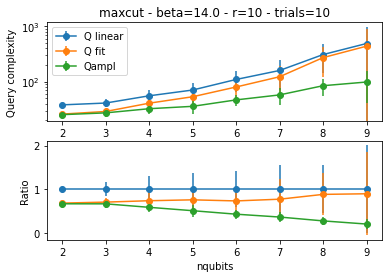

In [5]:
fig, axs = plt.subplots(2)
axs[0].set_title('maxcut - beta=%.1f - r=%d - trials=%d' % (beta, r, ntrials))
axs[0].errorbar(range(2,10), np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='Q linear')
axs[0].errorbar(range(2,10), np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='Q fit')
axs[0].errorbar(range(2,10), np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='Qampl')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(range(2,10), np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('nqubits')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_beta%d_r%d_pol5.png' % (beta, r), bbox_inches='tight')

## Example 5 - Average vs beta

In [119]:
# setup
ntrials = 10
nqubits = 5
npol = 1

def myschedule(t, params):
    #f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    #f += (1 - np.sum(params)) * t
    #return f
    return t**params[0]


r_range = range(3, 25) 
beta_max = 300
alpha_c = 0.5
alpha_ampl = 0.7
beta_range = range(2, beta_max+1, 10)
qref = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qampl_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
qc_alpha = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
bestr_opt = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f' beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        
        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='BFGS') #, bounds=[[-100, 100]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f' beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]

trial=0
 beta=2, r=3, reference=30.534679986164768
 beta=2, r=4, reference=35.550730589143
 beta=2, r=5, reference=41.49992742968455
 beta=2, r=6, reference=48.10091541400166
 beta=2, r=7, reference=55.23449262837951
 beta=2, r=8, reference=62.841769992611184
 beta=2, r=9, reference=70.88993665277366
 beta=2, r=10, reference=79.35877894559101
 beta=2, r=11, reference=88.23472419029422
 beta=2, r=12, reference=97.50796447620358
 beta=2, r=13, reference=107.17096455202957
 beta=2, r=14, reference=117.21764002593679
 beta=2, r=15, reference=127.64288086156404
 beta=2, r=16, reference=138.4422622740676
 beta=2, r=17, reference=149.6118620190996
 beta=2, r=18, reference=161.14814052579743
 beta=2, r=19, reference=173.0478594894336
 beta=2, r=20, reference=185.30802477042792
 beta=2, r=21, reference=197.9258451163279
 beta=2, r=22, reference=210.89870147169862
 beta=2, r=23, reference=224.22412355820475
 beta=2, r=24, reference=237.8997715698936
 beta=2, r=3, opt result=7.450750760388668, pa

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 48.10091541400166
 hess_inv: array([[1]])
      jac: array([2.61995888])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 55.23449262837951
 hess_inv: array([[1]])
      jac: array([5.4298501])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 62.841769992611184
 hess_inv: array([[1]])
      jac: array([8.32344389])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 70.88993665277366
 hess_inv: array([[1]])
      jac: array([11.30209923])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 79.35877894559101
 hess_inv: array([[1]])
      jac: array([14.37091351])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 88.23472419029422
 hess_inv: array([[1]])
      jac: array([17.53534222])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: inv

      fun: 97.50796447620358
 hess_inv: array([[1]])
      jac: array([20.80018044])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 107.17096455202957
 hess_inv: array([[1]])
      jac: array([24.16936302])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 117.21764002593679
 hess_inv: array([[1]])
      jac: array([27.64600849])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 127.64288086156404
 hess_inv: array([[1]])
      jac: array([31.23255348])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 138.4422622740676
 hess_inv: array([[1]])
      jac: array([34.93086624])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 149.6118620190996
 hess_inv: array([[1]])
      jac: array([38.74238014])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 161.14814052579743
 hess_inv: array([[1]])
      jac: array([42.66816521])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 173.0478594894336
 hess_inv: array([[1]])
      jac: array([46.7090168])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 185.30802477042792
 hess_inv: array([[1]])
      jac: array([50.86549759])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 197.9258451163279
 hess_inv: array([[1]])
      jac: array([55.13801575])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 210.89870147169862
 hess_inv: array([[1]])
      jac: array([59.52681923])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 224.22412355820475
 hess_inv: array([[1]])
      jac: array([64.03206444])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 237.8997715698936
 hess_inv: array([[1]])
      jac: array([68.65379906])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=124.66309639684106
 beta=12, r=4, reference=121.16716048316921
 beta=12, r=5, reference=121.98199866107385
 beta=12, r=6, reference=125.26044572746167
 beta=12, r=7, reference=130.18401902862044
 beta=12, r=8, reference=136.32496748310515
 beta=12, r=9, reference=143.4338017655886
 beta=12, r=10, reference=151.35317877800438
 beta=12, r=11, reference=159.97787609796524
 beta=12, r=12, reference=169.23421841436436
 beta=12, r=13, reference=179.06865910048623
 beta=12, r=14, reference=189.4410497856401
 beta=12, r=15, reference=200.32047654159126
 beta=12, r=16, reference=211.6825794761189
 beta=12, r=17, reference=223.5077688517815
 beta=12, r=18, reference=235.78000371628508
 beta=12, r=19, reference=248.4859349

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[3029.42429962] success=True
 beta=12, r=5, opt result=86.96510196786907, param=[2.83727648] success=True
 beta=12, r=6, opt result=99.97964360632064, param=[2.22343434] success=True
 beta=12, r=7, opt result=112.08768314812629, param=[1.87366942] success=True
 beta=12, r=8, opt result=123.65095185594387, param=[1.64040331] success=True
 beta=12, r=9, opt result=134.879245307445, param=[1.47167848] success=True
 beta=12, r=10, opt result=145.9045899371087, param=[1.34296017] success=True
 beta=12, r=11, opt result=156.81449359706286, param=[1.24092616] success=True
 beta=12, r=12, opt result=167.669254680322, param=[1.15765907] success=True
 beta=12, r=13, opt result=178.51172509761045, param=[1.08813674] success=True
 beta=12, r=14, opt result=189.37314111532442, param=[1.02900993] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 200.32047654159126
 hess_inv: array([[1]])
      jac: array([3.9360199])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])
      fun: 211.6825794761189
 hess_inv: array([[1]])
      jac: array([12.96209145])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 223.5077688517815
 hess_inv: array([[1]])
      jac: array([22.33649445])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 235.78000371628508
 hess_inv: array([[1]])
      jac: array([32.04810715])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 248.4859349038872
 hess_inv: array([[1]])
      jac: array([42.08813095])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 261.6142906405713
 hess_inv: array([[1]])
      jac: array([52.44941711])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 275.15542760336234
 hess_inv: array([[1]])
      jac: array([63.12610626])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 289.1009972348116
 hess_inv: array([[1]])
      jac: array([74.11328506])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 303.44369387458596
 hess_inv: array([[1]])
      jac: array([85.40678787])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 318.1770619653234
 hess_inv: array([[1]])
      jac: array([97.00302505])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=181.19160938977677
 beta=22, r=4, reference=171.91364293014095
 beta=22, r=5, reference=169.33480230222966
 beta=22, r=6, reference=170.20842195231947
 beta=22, r=7, reference=173.18872562006888
 beta=22, r=8, reference=177.61681501653337
 beta=22, r=9, reference=183.1292332263794
 beta=22, r=10, reference=189.5069187129134
 beta=22, r=11, reference=196.608617402136
 beta=22, r=12, reference=204.33831301622553
 beta=22, r=13, reference=212.62792110472392
 beta=22, r=14, reference=221.42745814275528
 beta=22, r=15, reference=230.6991442002073
 beta=22, r=16, reference=240.41370259439765
 beta=22, r=17, reference=250.54794920982573
 beta=22, r=18, reference=261.0831712931776
 beta=22, r=19, reference=272.004007074

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=5, opt result=98.82714455531571, param=[3.4379151] success=True
 beta=22, r=6, opt result=112.53942835610775, param=[2.76490763] success=True
 beta=22, r=7, opt result=125.54795739419967, param=[2.36723241] success=True
 beta=22, r=8, opt result=138.09429083204122, param=[2.09731184] success=True
 beta=22, r=9, opt result=150.33275172469874, param=[1.89988398] success=True
 beta=22, r=10, opt result=162.36861116495882, param=[1.74813322] success=True
 beta=22, r=11, opt result=174.27731496756738, param=[1.62723383] success=True
 beta=22, r=12, opt result=186.11491369259167, param=[1.52824911] success=True
 beta=22, r=13, opt result=197.92412553603307, param=[1.44544301] success=True
 beta=22, r=14, opt result=209.7381157840997, param=[1.37495097] success=True
 beta=22, r=15, opt result=221.58299519239822, param=[1.31406765] success=True
 beta=22, r=16, opt result=233.4795483441317, param=[1.26083879] success=True
 beta=22, r=17, opt result=245.44447063777557, param=[1.21381

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 332.00562040804533
 hess_inv: array([[1]])
      jac: array([3.47936249])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=232.66763743068455
 beta=32, r=4, reference=217.49705252010384
 beta=32, r=5, reference=211.92959314324173
 beta=32, r=6, reference=211.11130558120553
 beta=32, r=7, reference=213.03713354656594
 beta=32, r=8, reference=216.7441828820528
 beta=32, r=9, reference=221.71698623394605
 beta=32, r=10, reference=227.65525660343533
 beta=32, r=11, reference=234.37175521172634
 beta=32, r=12, reference=241.7430860264025
 beta=32, r=13, reference=249.68414675211218
 beta=32, r=14, reference=258.13399439779624
 beta=32, r=15, reference=267.04758878054264
 beta=32, r=16, reference=276.3907388889718
 beta=32, r=17, reference=286.1368829774641
 beta=32, r=18, reference=296.2649650201994
 beta=32, r=19, reference=306.75799199

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=32, r=5, opt result=111.55421416560723, param=[3.79116103] success=True
 beta=32, r=6, opt result=125.69948227301492, param=[3.09588294] success=True
 beta=32, r=7, opt result=139.31154329628504, param=[2.67259772] success=True
 beta=32, r=8, opt result=152.566801125713, param=[2.38166173] success=True
 beta=32, r=9, opt result=165.5780799679805, param=[2.16729908] success=True
 beta=32, r=10, opt result=178.42368170385532, param=[2.00163603] success=True
 beta=32, r=11, opt result=191.1611646373199, param=[1.86908431] success=True
 beta=32, r=12, opt result=203.83485617722204, param=[1.76018578] success=True
 beta=32, r=13, opt result=216.480055095459, param=[1.66883758] success=True
 beta=32, r=14, opt result=229.1255066401531, param=[1.59090954] success=True
 beta=32, r=15, opt result=241.7949629548269, param=[1.52349721] success=True
 beta=32, r=16, opt result=254.5082378648348, param=[1.46449331] success=True
 beta=32, r=17, opt result=267.28196526102886, param=[1.41232858] 

 beta=62, r=10, opt result=223.72682516767182, param=[2.45132596] success=True
 beta=62, r=11, opt result=238.13482115659443, param=[2.30023047] success=True
 beta=62, r=12, opt result=252.562246508793, param=[2.17529507] success=True
 beta=62, r=13, opt result=267.02152799827206, param=[2.06988354] success=True
 beta=62, r=14, opt result=281.5231757761564, param=[1.97948119] success=True
 beta=62, r=15, opt result=296.076620181159, param=[1.90090339] success=True
 beta=62, r=16, opt result=310.69062462434556, param=[1.83183303] success=True
 beta=62, r=17, opt result=325.3734709904476, param=[1.77053916] success=True
 beta=62, r=18, opt result=340.133028383831, param=[1.71569988] success=True
 beta=62, r=19, opt result=354.97676669460435, param=[1.66628561] success=True
 beta=62, r=20, opt result=369.9117481975561, param=[1.62148114] success=True
 beta=62, r=21, opt result=384.94461432330746, param=[1.58063141] success=True
 beta=62, r=22, opt result=400.0815757143419, param=[1.543203

 beta=92, r=13, opt result=313.4279906404502, param=[2.31144896] success=True
 beta=92, r=14, opt result=329.1562849626407, param=[2.21462661] success=True
 beta=92, r=15, opt result=344.9912003661919, param=[2.13023975] success=True
 beta=92, r=16, opt result=360.93193745660597, param=[2.05586143] success=True
 beta=92, r=17, opt result=376.9783053617062, param=[1.98967923] success=True
 beta=92, r=18, opt result=393.1307604836128, param=[1.93031007] success=True
 beta=92, r=19, opt result=409.39036655820627, param=[1.87667754] success=True
 beta=92, r=20, opt result=425.75871549978115, param=[1.82793006] success=True
 beta=92, r=21, opt result=442.2378326741829, param=[1.78338308] success=True
 beta=92, r=22, opt result=458.8300803912916, param=[1.74247981] success=True
 beta=92, r=23, opt result=475.53806727176607, param=[1.70476132] success=True
 beta=92, r=24, opt result=492.36456734115296, param=[1.66984556] success=True
 beta=102, r=3, reference=562.9153811945556
 beta=102, r=4,

 beta=122, r=15, opt result=391.2757167765569, param=[2.29513358] success=True
 beta=122, r=16, opt result=408.1937846661113, param=[2.2174365] success=True
 beta=122, r=17, opt result=425.2606533492398, param=[2.14819068] success=True
 beta=122, r=18, opt result=442.47123583971796, param=[2.08596966] success=True
 beta=122, r=19, opt result=459.821457690801, param=[2.02966408] success=True
 beta=122, r=20, opt result=477.3081992852741, param=[1.97839748] success=True
 beta=122, r=21, opt result=494.92920888425175, param=[1.93146657] success=True
 beta=122, r=22, opt result=512.6830024206893, param=[1.88829955] success=True
 beta=122, r=23, opt result=530.5687600901722, param=[1.84842604] success=True
 beta=122, r=24, opt result=548.5862258960846, param=[1.81145486] success=True
 beta=132, r=3, reference=700.5777705043884
 beta=132, r=4, reference=613.4269297473759
 beta=132, r=5, reference=568.1157548217897
 beta=132, r=6, reference=543.6441040557258
 beta=132, r=7, reference=531.0003

 beta=152, r=16, opt result=453.7514752722724, param=[2.34365231] success=True
 beta=152, r=17, opt result=471.61480313857993, param=[2.27229177] success=True
 beta=152, r=18, opt result=489.65985824192006, param=[2.20810457] success=True
 beta=152, r=19, opt result=507.87881457042835, param=[2.149955] success=True
 beta=152, r=20, opt result=526.2649633737395, param=[2.09694659] success=True
 beta=152, r=21, opt result=544.8126537880268, param=[2.04836082] success=True
 beta=152, r=22, opt result=563.5172123203795, param=[2.00361449] success=True
 beta=152, r=23, opt result=582.3748519328487, param=[1.96222818] success=True
 beta=152, r=24, opt result=601.382577796932, param=[1.92380389] success=True
 beta=162, r=3, reference=837.6418825482335
 beta=162, r=4, reference=727.4346143045861
 beta=162, r=5, reference=668.7446540561123
 beta=162, r=6, reference=635.7972162116741
 beta=162, r=7, reference=617.5202986773952
 beta=162, r=8, reference=608.3671474707517
 beta=162, r=9, reference

 beta=182, r=18, opt result=535.4640414785117, param=[2.30854422] success=True
 beta=182, r=19, opt result=554.3945672886059, param=[2.24904668] success=True
 beta=182, r=20, opt result=573.5226926305791, param=[2.19476614] success=True
 beta=182, r=21, opt result=592.8401634541618, param=[2.14497104] success=True
 beta=182, r=22, opt result=612.3397907230528, param=[2.09906816] success=True
 beta=182, r=23, opt result=632.0153777764899, param=[2.0565705] success=True
 beta=182, r=24, opt result=651.8616399875835, param=[2.01707422] success=True
 beta=192, r=3, reference=974.3700096131205
 beta=192, r=4, reference=840.9096301558776
 beta=192, r=5, reference=768.6131059345565
 beta=192, r=6, reference=726.9406335363641
 beta=192, r=7, reference=702.7693901818014
 beta=192, r=8, reference=689.5187459181473
 beta=192, r=9, reference=683.523593073672
 beta=192, r=10, reference=682.5820403511607
 beta=192, r=11, reference=685.2938952275997
 beta=192, r=12, reference=690.7288295750267
 beta=

 beta=212, r=21, opt result=639.5672625404839, param=[2.22730944] success=True
      fun: 659.7438573835296
 hess_inv: array([[0.00441544]])
      jac: array([1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 114
      nit: 7
     njev: 51
   status: 2
  success: False
        x: array([2.18052933])
 beta=212, r=23, opt result=680.1194502087266, param=[2.13718787] success=True
 beta=212, r=24, opt result=700.6868912878721, param=[2.09687552] success=True
 beta=222, r=3, reference=1110.8906461598315
 beta=222, r=4, reference=954.0504840275291
 beta=222, r=5, reference=867.9966231027813
 beta=222, r=6, reference=817.4293833441345
 beta=222, r=7, reference=787.1807764272896
 beta=222, r=8, reference=769.6418314039329
 beta=222, r=9, reference=760.5706201244309
 beta=222, r=10, reference=757.4142983951715
 beta=222, r=11, reference=758.54531110325
 beta=222, r=12, reference=762.878571765203
 beta=222, r=13, reference=769.6645921343807
 b

 beta=242, r=17, opt result=604.717574910239, param=[2.53541748] success=True
 beta=242, r=18, opt result=624.4867563549036, param=[2.46781648] success=True
 beta=242, r=19, opt result=644.5222778529361, param=[2.4064858] success=True
 beta=242, r=20, opt result=664.8112872505108, param=[2.35048393] success=True
 beta=242, r=21, opt result=685.3420293021134, param=[2.29905686] success=True
 beta=242, r=22, opt result=706.1038251633203, param=[2.25159426] success=True
 beta=242, r=23, opt result=727.0870325177151, param=[2.20759602] success=True
 beta=242, r=24, opt result=748.2829934272983, param=[2.16664808] success=True
 beta=252, r=3, reference=1247.2741649899153
 beta=252, r=4, reference=1066.9679169892868
 beta=252, r=5, reference=967.0518853999401
 beta=252, r=6, reference=907.4693190286738
 beta=252, r=7, reference=871.0104700562489
 beta=252, r=8, reference=849.041635345335
 beta=252, r=9, reference=836.7475551402392
 beta=252, r=10, reference=831.22757482135
 beta=252, r=11, r

 beta=272, r=18, opt result=668.1431153648159, param=[2.53321258] success=True
 beta=272, r=19, opt result=688.6195029241753, param=[2.47123475] success=True
 beta=272, r=20, opt result=709.3743929476012, param=[2.41462976] success=True
 beta=272, r=21, opt result=730.3948593539768, param=[2.36263423] success=True
 beta=272, r=22, opt result=751.6690238876116, param=[2.3146303] success=True
 beta=272, r=23, opt result=773.1860287889921, param=[2.27011192] success=True
 beta=272, r=24, opt result=794.9359961011867, param=[2.2286605] success=True
 beta=282, r=3, reference=1383.5623445370452
 beta=282, r=4, reference=1179.7285936719006
 beta=282, r=5, reference=1065.8746059010882
 beta=282, r=6, reference=997.1880996600153
 beta=282, r=7, reference=954.419648314842
 beta=282, r=8, reference=927.9131887086074
 beta=282, r=9, reference=912.2825705080256
 beta=282, r=10, reference=904.281662115497
 beta=282, r=11, reference=901.8356152805075
 beta=282, r=12, reference=903.555897448806
 beta=

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=2, r=4, opt result=7.450750760388669, param=[3026.17352367] success=True
 beta=2, r=5, opt result=36.27427102178894, param=[0.96012231] success=True
      fun: 42.17676214718725
 hess_inv: array([[1]])
      jac: array([2.02288246])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 48.50163270866638
 hess_inv: array([[1]])
      jac: array([4.02341557])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 55.21223635421795
 hess_inv: array([[1]])
      jac: array([6.07442617])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 62.287467758567225
 hess_inv: array([[1]])
      jac: array([8.17970371])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 69.71428947382557
 hess_inv: array([[1]])
      jac: array([10.34452248])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 77.48382968385474
 hess_inv: array([[1]])
      jac: array([12.5737772])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 85.58953852621097
 hess_inv: array([[1]])
      jac: array([14.87154675])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 94.02625118031811
 hess_inv: array([[1]])
      jac: array([17.24107552])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 102.78968177429581
 hess_inv: array([[1]])
      jac: array([19.68489838])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 111.87613512559095
 hess_inv: array([[1]])
      jac: array([22.20497799])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 121.28233457095608
 hess_inv: array([[1]])
      jac: array([24.80282784])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 131.00531454379595
 hess_inv: array([[1]])
      jac: array([27.47959137])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 141.04235074757526
 hess_inv: array([[1]])
      jac: array([30.23614311])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 151.39091296898556
 hess_inv: array([[1]])
      jac: array([33.07313347])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 162.04863198955715
 hess_inv: array([[1]])
      jac: array([35.99105835])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 173.0132755573011
 hess_inv: array([[1]])
      jac: array([38.99023819])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 184.2827303572267
 hess_inv: array([[1]])
      jac: array([42.07092285])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 195.85498806943593
 hess_inv: array([[1]])
      jac: array([45.23326492])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 207.72813429052903
 hess_inv: array([[1]])
      jac: array([48.47734451])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=123.49626647119167
 beta=12, r=4, reference=121.3197297821996
 beta=12, r=5, reference=123.56267708136879
 beta=12, r=6, reference=128.31917397298062
 beta=12, r=7, reference=134.74616735674047
 beta=12, r=8, reference=142.40754039497529
 beta=12, r=9, reference=151.05250329626898
 beta=12, r=10, reference=160.5253136004223
 beta=12, r=11, reference=170.72337070612414
 beta=12, r=12, reference=181.575805006348
 beta=12, r=13, reference=193.03170462934406
 beta=12, r=14, reference=205.05325439990457
 beta=12, r=15, reference=217.61154404268478
 beta=12, r=16, reference=230.68390447769204
 beta=12, r=17, reference=244.25215772697732
 beta=12, r=18, reference=258.30143351058143
 beta=12, r=19, reference=272.819348

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[2727.78407353] success=True
 beta=12, r=5, opt result=93.6002455150641, param=[2.94741538] success=True
 beta=12, r=6, opt result=108.07848532169938, param=[2.16538995] success=True
 beta=12, r=7, opt result=121.35624835474421, param=[1.78871934] success=True
 beta=12, r=8, opt result=133.94617462016427, param=[1.54569493] success=True
 beta=12, r=9, opt result=146.11195834939198, param=[1.37250032] success=True
 beta=12, r=10, opt result=158.01344384458133, param=[1.24144133] success=True
 beta=12, r=11, opt result=169.7542642683597, param=[1.13804738] success=True
 beta=12, r=12, opt result=181.4046875428382, param=[1.05390795] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 193.03170462934406
 hess_inv: array([[1]])
      jac: array([2.16787148])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
      fun: 205.05325439990457
 hess_inv: array([[1]])
      jac: array([11.16190338])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 217.61154404268478
 hess_inv: array([[1]])
      jac: array([20.49477386])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 230.68390447769204
 hess_inv: array([[1]])
      jac: array([30.15661621])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 244.25215772697732
 hess_inv: array([[1]])
      jac: array([40.14021301])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 258.30143351058143
 hess_inv: array([[1]])
      jac: array([50.44012451])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 272.8193486446458
 hess_inv: array([[1]])
      jac: array([61.0521698])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 287.79542520568566
 hess_inv: array([[1]])
      jac: array([71.97296524])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 303.2206696981597
 hess_inv: array([[1]])
      jac: array([83.19975281])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 319.087263164093
 hess_inv: array([[1]])
      jac: array([94.73019409])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 335.3883292391336
 hess_inv: array([[1]])
      jac: array([106.56226349])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 352.11775794376086
 hess_inv: array([[1]])
      jac: array([118.69414139])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=181.23203491592906
 beta=22, r=4, reference=172.2970833187005
 beta=22, r=5, reference=170.2789453294414
 beta=22, r=6, reference=171.88880861345038
 beta=22, r=7, reference=175.7369640709333
 beta=22, r=8, reference=181.13177199386578
 beta=22, r=9, reference=187.68765175210305
 beta=22, r=10, reference=195.17098482328134
 beta=22, r=11, reference=203.43093939244815
 beta=22, r=12, reference=212.36513536829457
 beta=22, r=13, reference=221.90120467524244
 beta=22, r=14, reference=231.98624099101738
 beta=22, r=15, reference=242.58044329388048
 beta=22, r=16, reference=253.653118835327
 beta=22, r=17, reference=265.1800780220455
 beta=22, r=18, reference=277.1418840058087
 beta=22, r=19, reference=289.52264534

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=4, opt result=37.46062058653759, param=[2509.52562672] success=True
 beta=22, r=5, opt result=105.90262189040752, param=[3.56304238] success=True
 beta=22, r=6, opt result=121.12831977380725, param=[2.69994396] success=True
 beta=22, r=7, opt result=135.38249671794756, param=[2.27719222] success=True
 beta=22, r=8, opt result=149.0299248495943, param=[1.99890109] success=True
 beta=22, r=9, opt result=162.27266377102313, param=[1.79807438] success=True
 beta=22, r=10, opt result=175.24280685991187, param=[1.64486867] success=True
 beta=22, r=11, opt result=188.0327327826851, param=[1.52338125] success=True
 beta=22, r=12, opt result=200.70987328843972, param=[1.42422167] success=True
 beta=22, r=13, opt result=213.32491170284146, param=[1.34144102] success=True
 beta=22, r=14, opt result=225.91675079432025, param=[1.27106825] success=True
 beta=22, r=15, opt result=238.51572717391872, param=[1.21034217] success=True
 beta=22, r=16, opt result=251.1457954329045, param=[1.157

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 315.4903220754404
 hess_inv: array([[1]])
      jac: array([10.15678787])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 329.0566318095913
 hess_inv: array([[1]])
      jac: array([19.79730988])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 342.9999009804108
 hess_inv: array([[1]])
      jac: array([29.72771072])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 357.3129795262174
 hess_inv: array([[1]])
      jac: array([39.94436264])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=232.6790006493513
 beta=32, r=4, reference=217.5834360429547
 beta=32, r=5, reference=212.19714474254906
 beta=32, r=6, reference=211.68381281154097
 beta=32, r=7, reference=214.03372819748992
 beta=32, r=8, reference=218.26986299559942
 beta=32, r=9, reference=223.86116256584157
 beta=32, r=10, reference=230.49362480168543
 beta=32, r=11, reference=237.96897967235537
 beta=32, r=12, reference=246.15528997081526
 beta=32, r=13, reference=254.96092825220026
 beta=32, r=14, reference=264.3199694383751
 beta=32, r=15, reference=274.183545645518
 beta=32, r=16, reference=284.51449621044077
 beta=32, r=17, reference=295.28392888270304
 beta=32, r=18, reference=306.4689364182304
 beta=32, r=19, reference=318.051037236

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=32, r=4, opt result=51.259903504716156, param=[2959.67432161] success=True
 beta=32, r=5, opt result=118.05449376012642, param=[3.95618635] success=True
 beta=32, r=6, opt result=133.608938703464, param=[3.03126586] success=True
 beta=32, r=7, opt result=148.39986883361266, param=[2.58173408] success=True
 beta=32, r=8, opt result=162.70109292546314, param=[2.28263058] success=True
 beta=32, r=9, opt result=176.66654909112043, param=[2.06520155] success=True
 beta=32, r=10, opt result=190.39806613099893, param=[1.89840262] success=True
 beta=32, r=11, opt result=203.96835062400507, param=[1.76555235] success=True
 beta=32, r=12, opt result=217.43221639490412, param=[1.65674243] success=True
 beta=32, r=13, opt result=230.83256978332219, param=[1.56566394] success=True
 beta=32, r=14, opt result=244.20385456252575, param=[1.4880845] success=True
 beta=32, r=15, opt result=257.57418960728637, param=[1.42104757] success=True
 beta=32, r=16, opt result=270.9667919100332, param=[1.362

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=62, r=6, opt result=172.6978449464955, param=[3.59659915] success=True
 beta=62, r=7, opt result=188.36327328066437, param=[3.11161975] success=True
 beta=62, r=8, opt result=203.81248211257673, param=[2.78063105] success=True
 beta=62, r=9, opt result=219.1315147620582, param=[2.53711957] success=True
 beta=62, r=10, opt result=234.3726426988322, param=[2.34872805] success=True
 beta=62, r=11, opt result=249.56993444768003, param=[2.19761221] success=True
 beta=62, r=12, opt result=264.7473492366006, param=[2.07305188] success=True
 beta=62, r=13, opt result=279.92316070104505, param=[1.96818277] success=True
 beta=62, r=14, opt result=295.1123586303249, param=[1.8783839] success=True
 beta=62, r=15, opt result=310.3279389748067, param=[1.80041971] success=True
 beta=62, r=16, opt result=325.5815861383728, param=[1.73194743] success=True
      fun: 340.88402587012405
 hess_inv: array([[0.00702047]])
      jac: array([1.14440918e-05])
  message: 'Desired error not necessarily ach

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=72, r=7, opt result=201.7794959353891, param=[3.22845325] success=True
 beta=72, r=8, opt result=217.46572950948513, param=[2.89148784] success=True
 beta=72, r=9, opt result=233.07640408073283, param=[2.64278615] success=True
 beta=72, r=10, opt result=248.6554719715085, param=[2.45005414] success=True
 beta=72, r=11, opt result=264.2298954204286, param=[2.29526209] success=True
 beta=72, r=12, opt result=279.8173478055697, param=[2.16752759] success=True
 beta=72, r=13, opt result=295.4304756544454, param=[2.05986738] success=True
 beta=72, r=14, opt result=311.07925375586376, param=[1.96757712] success=True
 beta=72, r=15, opt result=326.7722594471292, param=[1.88736114] success=True
 beta=72, r=16, opt result=342.51733788324066, param=[1.81683477] success=True
 beta=72, r=17, opt result=358.3219275322358, param=[1.75422422] success=True
 beta=72, r=18, opt result=374.1931998499714, param=[1.6981791] success=True
 beta=72, r=19, opt result=390.1381012951511, param=[1.64765064]

 beta=102, r=9, opt result=274.5651556340532, param=[2.88616401] success=True
 beta=102, r=10, opt result=290.8926551373523, param=[2.68412272] success=True
 beta=102, r=11, opt result=307.3172574008828, param=[2.52143422] success=True
 beta=102, r=12, opt result=323.8447679897019, param=[2.38690491] success=True
 beta=102, r=13, opt result=340.47671467761694, param=[2.27329369] success=True
 beta=102, r=14, opt result=357.2126418915606, param=[2.17570461] success=True
 beta=102, r=15, opt result=374.05141922519414, param=[2.09070331] success=True
 beta=102, r=16, opt result=390.9919614261099, param=[2.01580454] success=True
 beta=102, r=17, opt result=408.03359560959177, param=[1.949162] success=True
 beta=102, r=18, opt result=425.17621869413557, param=[1.88937105] success=True
 beta=102, r=19, opt result=442.4203325292751, param=[1.83534278] success=True
      fun: 459.7670105206898
 hess_inv: array([[3.03261913e-08]])
      jac: array([1.14440918e-05])
  message: 'Desired error not

 beta=132, r=5, opt result=249.73904144726401, param=[5.01334901] success=True
 beta=132, r=6, opt result=266.133473177527, param=[4.19056253] success=True
 beta=132, r=7, opt result=282.5682736407066, param=[3.68484515] success=True
 beta=132, r=8, opt result=299.09032874558375, param=[3.32967369] success=True
 beta=132, r=9, opt result=315.75701869150816, param=[3.06322971] success=True
 beta=132, r=10, opt result=332.5928539259844, param=[2.85505372] success=True
 beta=132, r=11, opt result=349.60581182274905, param=[2.68709747] success=True
 beta=132, r=12, opt result=366.79560936758963, param=[2.54804856] success=True
 beta=132, r=13, opt result=384.15776060652234, param=[2.43050813] success=True
 beta=132, r=14, opt result=401.68585504783385, param=[2.32944822] success=True
 beta=132, r=15, opt result=419.37289336186035, param=[2.24133248] success=True
 beta=132, r=16, opt result=437.21206409303807, param=[2.16359995] success=True
 beta=132, r=17, opt result=455.1971748817393, pa

 beta=162, r=6, opt result=306.46614186610174, param=[4.34627664] success=True
 beta=162, r=7, opt result=323.06204068179875, param=[3.83257482] success=True
 beta=162, r=8, opt result=339.821479806721, param=[3.47272534] success=True
 beta=162, r=9, opt result=356.79400617983686, param=[3.20164143] success=True
 beta=162, r=10, opt result=374.00233110009435, param=[2.98909473] success=True
 beta=162, r=11, opt result=391.45154495701047, param=[2.81730415] success=True
 beta=162, r=12, opt result=409.1380922400103, param=[2.67495218] success=True
 beta=162, r=13, opt result=427.05406505253484, param=[2.55455519] success=True
 beta=162, r=14, opt result=445.18951985077405, param=[2.45099207] success=True
 beta=162, r=15, opt result=463.5338330993586, param=[2.36064983] success=True
 beta=162, r=16, opt result=482.0765122433561, param=[2.2809072] success=True
 beta=162, r=17, opt result=500.80767185541816, param=[2.2098149] success=True
 beta=162, r=18, opt result=519.718296700635, param

 beta=192, r=9, opt result=397.74146858617155, param=[3.31479882] success=True
 beta=192, r=10, opt result=415.2373500687283, param=[3.09899144] success=True
 beta=192, r=11, opt result=433.0260608597683, param=[2.92426458] success=True
 beta=192, r=12, opt result=451.10229794004374, param=[2.77936092] success=True
 beta=192, r=13, opt result=469.45615312946796, param=[2.65675835] success=True
 beta=192, r=14, opt result=488.07551700320937, param=[2.55127561] success=True
 beta=192, r=15, opt result=506.9474620221105, param=[2.45924039] success=True
 beta=192, r=16, opt result=526.0590763505318, param=[2.37798242] success=True
 beta=192, r=17, opt result=545.3979689440988, param=[2.30551438] success=True
 beta=192, r=18, opt result=564.9525657942809, param=[2.24032603] success=True
 beta=192, r=19, opt result=584.7122698629947, param=[2.1812483] success=True
 beta=192, r=20, opt result=604.6675313139506, param=[2.12736138] success=True
 beta=192, r=21, opt result=624.8098588978457, par

 beta=222, r=12, opt result=492.81422893623585, param=[2.86788695] success=True
 beta=222, r=13, opt result=511.5252859278479, param=[2.74351446] success=True
 beta=222, r=14, opt result=530.5416684476215, param=[2.63649656] success=True
 beta=222, r=15, opt result=549.8489532557484, param=[2.54311745] success=True
 beta=222, r=16, opt result=569.4326057725051, param=[2.46066715] success=True
 beta=222, r=17, opt result=589.2785049805739, param=[2.38712636] success=True
 beta=222, r=18, opt result=609.3732624490558, param=[2.32095857] success=True
 beta=222, r=19, opt result=629.7044067810083, param=[2.26097498] success=True
 beta=222, r=20, opt result=650.260478312496, param=[2.20624028] success=True
 beta=222, r=21, opt result=671.0310636266271, param=[2.15600813] success=True
 beta=222, r=22, opt result=692.0067898853968, param=[2.10967514] success=True
 beta=222, r=23, opt result=713.179292721165, param=[2.06674787] success=True
 beta=222, r=24, opt result=734.5411672267767, param=

 beta=252, r=15, opt result=592.3824026734422, param=[2.61602232] success=True
 beta=252, r=16, opt result=612.3657828896406, param=[2.53260427] success=True
 beta=252, r=17, opt result=632.6428747600218, param=[2.45820013] success=True
 beta=252, r=18, opt result=653.1989860264298, param=[2.39125122] success=True
 beta=252, r=19, opt result=674.0202671027859, param=[2.33055071] success=True
 beta=252, r=20, opt result=695.0938241497012, param=[2.27514975] success=True
 beta=252, r=21, opt result=716.4077716593793, param=[2.22429024] success=True
 beta=252, r=22, opt result=737.9512438632754, param=[2.17736104] success=True
 beta=252, r=23, opt result=759.7143782849978, param=[2.13386151] success=True
 beta=252, r=24, opt result=781.6882807534845, param=[2.09337881] success=True
 beta=262, r=3, reference=1292.7126127896115
 beta=262, r=4, reference=1104.5697530032305
 beta=262, r=5, reference=1000.0150505102317
 beta=262, r=6, reference=937.4064493680628
 beta=262, r=7, reference=898.8

 beta=282, r=16, opt result=654.9688850698817, param=[2.5962164] success=True
 beta=282, r=17, opt result=675.6185094316868, param=[2.52110091] success=True
 beta=282, r=18, opt result=696.57458761316, param=[2.45351435] success=True
 beta=282, r=19, opt result=717.8222463184676, param=[2.39223412] success=True
 beta=282, r=20, opt result=739.3475048516478, param=[2.33629768] success=True
 beta=282, r=21, opt result=761.1373417104727, param=[2.28493799] success=True
 beta=282, r=22, opt result=783.1797196251013, param=[2.23753519] success=True
 beta=282, r=23, opt result=805.4635819794055, param=[2.19358255] success=True
 beta=282, r=24, opt result=827.9788296938959, param=[2.15266274] success=True
 beta=292, r=3, reference=1428.9754073755494
 beta=292, r=4, reference=1217.2884751218812
 beta=292, r=5, reference=1098.7751858486545
 beta=292, r=6, reference=1027.038290902547
 beta=292, r=7, reference=982.1487846172055
 beta=292, r=8, reference=954.1101971758759
 beta=292, r=9, reference

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 31.95456999457716
 hess_inv: array([[1]])
      jac: array([0.38745332])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 37.32536935903334
 hess_inv: array([[1]])
      jac: array([1.67788363])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 43.025132759287466
 hess_inv: array([[1]])
      jac: array([2.97735786])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 49.034512004006295
 hess_inv: array([[1]])
      jac: array([4.29244566])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 55.34321529450349
 hess_inv: array([[1]])
      jac: array([5.63079834])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 61.94488791480491
 hess_inv: array([[1]])
      jac: array([6.9988966])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: inv

      fun: 68.83505512809334
 hess_inv: array([[1]])
      jac: array([8.40180302])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 76.01021864834728
 hess_inv: array([[1]])
      jac: array([9.84338856])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 83.46743094211672
 hess_inv: array([[1]])
      jac: array([11.32657909])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 91.20408259495107
 hess_inv: array([[1]])
      jac: array([12.85360527])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 99.21779045019808
 hess_inv: array([[1]])
      jac: array([14.4261446])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 107.50633577208411
 hess_inv: array([[1]])
      jac: array([16.0454998])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 116.06762827744691
 hess_inv: array([[1]])
      jac: array([17.71265125])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 124.89968403279356
 hess_inv: array([[1]])
      jac: array([19.42835712])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 134.000611032318
 hess_inv: array([[1]])
      jac: array([21.19319534])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 143.36859917068463
 hess_inv: array([[1]])
      jac: array([23.00759697])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 153.00191281690715
 hess_inv: array([[1]])
      jac: array([24.87189674])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 162.898884986561
 hess_inv: array([[1]])
      jac: array([26.78633881])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 173.0579125391107
 hess_inv: array([[1]])
      jac: array([28.75109863])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 183.47745206543343
 hess_inv: array([[1]])
      jac: array([30.76629448])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=148.93681528909116
 beta=12, r=4, reference=147.55888085694036
 beta=12, r=5, reference=152.04858847876676
 beta=12, r=6, reference=159.86484996055222
 beta=12, r=7, reference=169.88200642786518
 beta=12, r=8, reference=181.5200815890548
 beta=12, r=9, reference=194.4486368792866
 beta=12, r=10, reference=208.46511745620444
 beta=12, r=11, reference=223.43807212110053
 beta=12, r=12, reference=239.27810594847008
 beta=12, r=13, reference=255.9219550031814
 beta=12, r=14, reference=273.32326579181824
 beta=12, r=15, reference=291.4470136562709
 beta=12, r=16, reference=310.26599535423213
 beta=12, r=17, reference=329.7585532334869
 beta=12, r=18, reference=349.90705661470133
 beta=12, r=19, reference=370.6968630

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[3232.52905303] success=True
 beta=12, r=5, opt result=23.38956871377144, param=[3669.97385503] success=True
 beta=12, r=6, opt result=144.28121357713567, param=[1.90221696] success=True
 beta=12, r=7, opt result=161.7187619028044, param=[1.53464841] success=True
 beta=12, r=8, opt result=177.95448871790026, param=[1.30544047] success=True
 beta=12, r=9, opt result=193.43912217960448, param=[1.14463154] success=True
 beta=12, r=10, opt result=208.43116026619546, param=[1.02405321] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 223.43807212110053
 hess_inv: array([[1]])
      jac: array([9.50375175])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
      fun: 239.27810594847008
 hess_inv: array([[1]])
      jac: array([22.22631454])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 255.9219550031814
 hess_inv: array([[1]])
      jac: array([35.30390358])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
      fun: 273.32326579181824
 hess_inv: array([[1]])
      jac: array([48.73368835])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 291.4470136562709
 hess_inv: array([[1]])
      jac: array([62.51698303])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 310.26599535423213
 hess_inv: array([[1]])
      jac: array([76.65703201])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 329.7585532334869
 hess_inv: array([[1]])
      jac: array([91.15781021])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 349.90705661470133
 hess_inv: array([[1]])
      jac: array([106.02333832])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 370.69686300524506
 hess_inv: array([[1]])
      jac: array([121.2573967])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 392.1155915690975
 hess_inv: array([[1]])
      jac: array([136.86332703])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 414.1526046700563
 hess_inv: array([[1]])
      jac: array([152.84400558])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 436.79863104857225
 hess_inv: array([[1]])
      jac: array([169.20188522])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 460.0454872856715
 hess_inv: array([[1]])
      jac: array([185.93893051])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 483.8858686857075
 hess_inv: array([[1]])
      jac: array([203.05669403])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.27648332309676
 beta=22, r=5, reference=246.24313288389214
 beta=22, r=6, reference=248.3721022323169
 beta=22, r=7, reference=254.32675498149345
 beta=22, r=8, reference=262.93393629338044
 beta=22, r=9, reference=273.53384529943696
 beta=22, r=10, reference=285.72347750789726
 beta=22, r=11, reference=299.2408660321006
 beta=22, r=12, reference=313.90726451166813
 beta=22, r=13, reference=329.59587189104843
 beta=22, r=14, reference=346.2138005072977
 beta=22, r=15, reference=363.6911288385638
 beta=22, r=16, reference=381.97396825196995
 beta=22, r=17, reference=401.0199150456814
 beta=22, r=18, reference=420.79497763754347
 beta=22, r=19, reference=441.27144730

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=4, opt result=37.46062058653759, param=[3224.82490205] success=True
 beta=22, r=5, opt result=37.46062058653759, param=[3205.79586264] success=True
 beta=22, r=6, opt result=188.18285888581562, param=[2.3782019] success=True
 beta=22, r=7, opt result=210.79900466793302, param=[1.97915161] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=8, opt result=231.9298421357985, param=[1.72222985] success=True
 beta=22, r=9, opt result=252.07068301605528, param=[1.53872794] success=True
 beta=22, r=10, opt result=271.5221224229896, param=[1.39956297] success=True
 beta=22, r=11, opt result=290.48278737415427, param=[1.28960476] success=True
 beta=22, r=12, opt result=309.09109231738637, param=[1.2000483] success=True
 beta=22, r=13, opt result=327.4471486939636, param=[1.12537152] success=True
 beta=22, r=14, opt result=345.62539556087336, param=[1.06191671] success=True
 beta=22, r=15, opt result=363.68238918863415, param=[1.00715596] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 381.97396825196995
 hess_inv: array([[1]])
      jac: array([15.08014297])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 401.0199150456814
 hess_inv: array([[1]])
      jac: array([33.10165024])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 420.79497763754347
 hess_inv: array([[1]])
      jac: array([51.60522842])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 441.2714473034119
 hess_inv: array([[1]])
      jac: array([70.58456421])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 462.4263900545927
 hess_inv: array([[1]])
      jac: array([90.03577805])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 484.2405576959716
 hess_inv: array([[1]])
      jac: array([109.95643997])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 506.6975879762903
 hess_inv: array([[1]])
      jac: array([130.34508514])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 529.7834079705665
 hess_inv: array([[1]])
      jac: array([151.20085907])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 553.4857827982232
 hess_inv: array([[1]])
      jac: array([172.52330017])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=375.95474382713866
 beta=32, r=4, reference=344.90411904379795
 beta=32, r=5, reference=332.0302591172619
 beta=32, r=6, reference=328.35395207582235
 beta=32, r=7, reference=330.1295583421775
 beta=32, r=8, reference=335.5221117852422
 beta=32, r=9, reference=343.524422645336
 beta=32, r=10, reference=353.53457114180276
 beta=32, r=11, reference=365.1683292710072
 beta=32, r=12, reference=378.1672577359625
 beta=32, r=13, reference=392.35001328020104
 beta=32, r=14, reference=407.5848467537049
 beta=32, r=15, reference=423.7732199669587
 beta=32, r=16, reference=440.83959727337054
 beta=32, r=17, reference=458.72483643031615
 beta=32, r=18, reference=477.38176702676765
 beta=32, r=19, reference=496.77214761267

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=32, r=4, opt result=51.259903504716156, param=[2615.34361861] success=True
 beta=32, r=5, opt result=188.7573529994949, param=[3.58545098] success=True
 beta=32, r=6, opt result=216.77561396954374, param=[2.66337306] success=True
 beta=32, r=7, opt result=242.2536440645958, param=[2.24691162] success=True
 beta=32, r=8, opt result=266.18065957896897, param=[1.97425737] success=True
 beta=32, r=9, opt result=289.0485076907092, param=[1.77759921] success=True
 beta=32, r=10, opt result=311.15828118873867, param=[1.62742452] success=True
 beta=32, r=11, opt result=332.71097387191764, param=[1.50815351] success=True
 beta=32, r=12, opt result=353.8489535110039, param=[1.41062999] success=True
 beta=32, r=13, opt result=374.67746022623913, param=[1.32906758] success=True
 beta=32, r=14, opt result=395.27675256298664, param=[1.25960845] success=True
 beta=32, r=15, opt result=415.7094695081238, param=[1.19957042] success=True
 beta=32, r=16, opt result=436.0253638206682, param=[1.14702

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 516.864519707304
 hess_inv: array([[1]])
      jac: array([7.3998642])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 537.6326616571653
 hess_inv: array([[1]])
      jac: array([27.84670258])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 559.0544535835818
 hess_inv: array([[1]])
      jac: array([48.80763245])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 581.1110301823057
 hess_inv: array([[1]])
      jac: array([70.27587891])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 603.7861389601362
 hess_inv: array([[1]])
      jac: array([92.24617004])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
 beta=42, r=3, reference=480.3017777606883
 beta=42, r=4, reference=432.9829248257296
 beta=42, r=5, reference=410.96140918818736
 beta=42, r=6, reference=401.4709713089811
 beta=42, r=7, reference=399.1955472123671
 beta=42, r=8, reference=401.5549277381115
 beta=42, r=9, reference=407.15269015729825
 beta=42, r=10, reference=415.1677294968759
 beta=42, r=11, reference=425.08449512182455
 beta=42, r=12, reference=436.5616353497189
 beta=42, r=13, reference=449.363050279409
 beta=42, r=14, reference=463.3193893418931
 beta=42, r=15, reference=478.3053997756493
 beta=42, r=16, reference=494.22599450525536
 beta=42, r=17, reference=511.00734823826787
 beta=42, r=18, reference=528.5910144019955
 beta=42, r=19, reference=546.9299232027755
 

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=42, r=4, opt result=64.96745840813456, param=[3005.15644243] success=True
 beta=42, r=5, opt result=208.96060829803636, param=[3.73126393] success=True
 beta=42, r=6, opt result=238.62077657131442, param=[2.86378729] success=True
 beta=42, r=7, opt result=265.81898342884693, param=[2.4368227] success=True
 beta=42, r=8, opt result=291.4814321729039, param=[2.15376131] success=True
 beta=42, r=9, opt result=316.08593433429184, param=[1.94823665] success=True
 beta=42, r=10, opt result=339.92496269329905, param=[1.79056896] success=True
 beta=42, r=11, opt result=363.1928377900707, param=[1.6649011] success=True
 beta=42, r=12, opt result=386.02698843708856, param=[1.56185099] success=True
 beta=42, r=13, opt result=408.5294216013689, param=[1.47546216] success=True
 beta=42, r=14, opt result=430.77868690826676, param=[1.40174928] success=True
 beta=42, r=15, opt result=452.8369594298719, param=[1.33793351] success=True
 beta=42, r=16, opt result=474.7544730293994, param=[1.2820114

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 648.8087846324396
 hess_inv: array([[1]])
      jac: array([3.64681244])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])
 beta=52, r=3, reference=578.9515128734919
 beta=52, r=4, reference=514.8853495817511
 beta=52, r=5, reference=483.45890790160183
 beta=52, r=6, reference=468.0738439754592
 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325876
 beta=52, r=9, reference=464.5437641261034
 beta=52, r=10, reference=470.7177762501185
 beta=52, r=11, reference=479.07595246073635
 beta=52, r=12, reference=489.1876759625793
 beta=52, r=13, reference=500.7587312964699
 beta=52, r=14, reference=513.5805739279417
 beta=52, r=15, reference=527.5006810366414
 beta=52, r=16, reference=542.4044604577907
 beta=52, r=17, reference=558.2037894104659
 beta=52, r=18, reference=574.8295099078621
 beta=52, r=19, reference=592.2263698451094
 bet

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=52, r=4, opt result=78.6330345378819, param=[2550.45432797] success=True
 beta=52, r=5, opt result=225.76200097300446, param=[3.84078922] success=True
 beta=52, r=6, opt result=256.29752354807306, param=[3.01625121] success=True
 beta=52, r=7, opt result=284.49485747772843, param=[2.58297806] success=True
 beta=52, r=8, opt result=311.2110457904249, param=[2.29251741] success=True
 beta=52, r=9, opt result=336.90490735640583, param=[2.0804959] success=True
 beta=52, r=10, opt result=361.85721684680925, param=[1.91728529] success=True
 beta=52, r=11, opt result=386.2530565798783, param=[1.78686209] success=True
 beta=52, r=12, opt result=410.22220275318773, param=[1.67968453] success=True
 beta=52, r=13, opt result=433.8604681275604, param=[1.58967274] success=True
 beta=52, r=14, opt result=457.2415980846528, param=[1.51274816] success=True
 beta=52, r=15, opt result=480.4242288025156, param=[1.44606188] success=True
 beta=52, r=16, opt result=503.4561501600974, param=[1.38755675

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=62, r=4, opt result=92.2759095268856, param=[2521.61652459] success=True
 beta=62, r=5, opt result=240.47565554269087, param=[3.92762754] success=True
 beta=62, r=6, opt result=271.41288542303107, param=[3.13839622] success=True
 beta=62, r=7, opt result=300.1599232464098, param=[2.70125241] success=True
 beta=62, r=8, opt result=327.49795058692206, param=[2.40527899] success=True
 beta=62, r=9, opt result=353.86516730332477, param=[2.18823418] success=True
 beta=62, r=10, opt result=379.52986118315425, param=[2.02069082] success=True
 beta=62, r=11, opt result=404.66752832641424, param=[1.88653537] success=True
 beta=62, r=12, opt result=429.3999036316893, param=[1.77611178] success=True
 beta=62, r=13, opt result=453.8159649523541, param=[1.68324438] success=True
 beta=62, r=14, opt result=477.9837353746938, param=[1.60378163] success=True
 beta=62, r=15, opt result=501.9571757871754, param=[1.53481912] success=True
 beta=62, r=16, opt result=525.7803616996946, param=[1.4742575

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=72, r=6, opt result=285.0460669114285, param=[3.24007543] success=True
 beta=72, r=7, opt result=314.07482930252127, param=[2.80034467] success=True
 beta=72, r=8, opt result=341.7718868679099, param=[2.50008397] success=True
 beta=72, r=9, opt result=368.55514657084535, param=[2.27899726] success=True
 beta=72, r=10, opt result=394.68092407142336, param=[2.10792872] success=True
 beta=72, r=11, opt result=420.31572558606837, param=[1.97072647] success=True
 beta=72, r=12, opt result=445.57377535959, param=[1.85765002] success=True
 beta=72, r=13, opt result=470.53754613545055, param=[1.76244807] success=True
 beta=72, r=14, opt result=495.2694186857451, param=[1.68090863] success=True
 beta=72, r=15, opt result=519.8185205079349, param=[1.61008133] success=True
 beta=72, r=16, opt result=544.2248586565282, param=[1.54783162] success=True
 beta=72, r=17, opt result=568.521891070203, param=[1.49257343] success=True
 beta=72, r=18, opt result=592.738174759259, param=[1.44310059] su

 beta=102, r=7, opt result=351.8115597837611, param=[3.02669467] success=True
 beta=102, r=8, opt result=379.8904433936631, param=[2.71743191] success=True
 beta=102, r=9, opt result=407.2170762496226, param=[2.48760957] success=True
 beta=102, r=10, opt result=434.0192278408269, param=[2.3088136] success=True
 beta=102, r=11, opt result=460.44258396795874, param=[2.16490185] success=True
 beta=102, r=12, opt result=486.58410923724506, param=[2.04598392] success=True
 beta=102, r=13, opt result=512.5111018356621, param=[1.9456493] success=True
 beta=102, r=14, opt result=538.2723210163084, param=[1.85955204] success=True
 beta=102, r=15, opt result=563.9046532287068, param=[1.78463614] success=True
 beta=102, r=16, opt result=589.437190877499, param=[1.71868562] success=True
 beta=102, r=17, opt result=614.893771155691, param=[1.66005132] success=True
 beta=102, r=18, opt result=640.2945788376629, param=[1.60747824] success=True
 beta=102, r=19, opt result=665.657170553277, param=[1.55

 beta=132, r=11, opt result=498.1663485797317, param=[2.30688899] success=True
 beta=132, r=12, opt result=524.7863192815566, param=[2.18388562] success=True
 beta=132, r=13, opt result=551.2682474247931, param=[2.07997605] success=True
 beta=132, r=14, opt result=577.6521718393966, param=[1.99072035] success=True
 beta=132, r=15, opt result=603.9667768723509, param=[1.91298532] success=True
 beta=132, r=16, opt result=630.2334395478379, param=[1.84449382] success=True
 beta=132, r=17, opt result=656.4687864565609, param=[1.78354857] success=True
 beta=132, r=18, opt result=682.6863260502021, param=[1.72885704] success=True
 beta=132, r=19, opt result=708.8974966458766, param=[1.67941608] success=True
 beta=132, r=20, opt result=735.1123400680962, param=[1.63443415] success=True
 beta=132, r=21, opt result=761.3399331846816, param=[1.59327744] success=True
 beta=132, r=22, opt result=787.5886620995203, param=[1.55543165] success=True
      fun: 813.8663940537624
 hess_inv: array([[0.00

 beta=162, r=5, opt result=366.7792373677865, param=[4.40195757] success=True
 beta=162, r=6, opt result=397.03455079273766, param=[3.76828735] success=True
 beta=162, r=7, opt result=425.97780854121476, param=[3.32049716] success=True
 beta=162, r=8, opt result=454.1092517731059, param=[2.99990395] success=True
 beta=162, r=9, opt result=481.7190871501064, param=[2.7592167] success=True
 beta=162, r=10, opt result=509.000930637387, param=[2.57082759] success=True
 beta=162, r=11, opt result=536.0791523607775, param=[2.41858542] success=True
 beta=162, r=12, opt result=563.0336765732642, param=[2.29243699] success=True
 beta=162, r=13, opt result=589.9166043960646, param=[2.18578615] success=True
 beta=162, r=14, opt result=616.762480846186, param=[2.09412056] success=True
 beta=162, r=15, opt result=643.5946592245064, param=[2.0142465] success=True
 beta=162, r=16, opt result=670.4293162313953, param=[1.94383781] success=True
 beta=162, r=17, opt result=697.2780253279891, param=[1.881

 beta=192, r=5, opt result=405.0681795998503, param=[4.49716448] success=True
 beta=192, r=6, opt result=435.1503525024481, param=[3.87368461] success=True
 beta=192, r=7, opt result=463.9743254707003, param=[3.42668666] success=True
 beta=192, r=8, opt result=492.0847309716655, param=[3.10218707] success=True
 beta=192, r=9, opt result=519.7567381321567, param=[2.85754819] success=True
 beta=192, r=10, opt result=547.1719587420293, param=[2.66571448] success=True
 beta=192, r=11, opt result=574.4485519840713, param=[2.51050503] success=True
 beta=192, r=12, opt result=601.6621463336589, param=[2.38179412] success=True
 beta=192, r=13, opt result=628.8611292278201, param=[2.27291685] success=True
 beta=192, r=14, opt result=656.0764981628796, param=[2.17930164] success=True
 beta=192, r=15, opt result=683.3280847026824, param=[2.0977051] success=True
 beta=192, r=16, opt result=710.6285314379114, param=[2.02576015] success=True
 beta=192, r=17, opt result=737.985872079878, param=[1.961

 beta=222, r=5, opt result=443.7667328864739, param=[4.58156512] success=True
 beta=222, r=6, opt result=473.7171406507231, param=[3.96228892] success=True
 beta=222, r=7, opt result=502.44473367362485, param=[3.51650604] success=True
 beta=222, r=8, opt result=530.5293741212291, param=[3.18900551] success=True
 beta=222, r=9, opt result=558.2446603275165, param=[2.9410143] success=True
 beta=222, r=10, opt result=585.7629226022013, param=[2.74624237] success=True
 beta=222, r=11, opt result=613.1972822894895, param=[2.58851376] success=True
 beta=222, r=12, opt result=640.6202784239763, param=[2.45763525] success=True
 beta=222, r=13, opt result=668.0778030763666, param=[2.34688006] success=True
 beta=222, r=14, opt result=695.5984946608284, param=[2.25162532] success=True
 beta=222, r=15, opt result=723.1998079130698, param=[2.16858522] success=True
 beta=222, r=16, opt result=750.8919436890963, param=[2.09535835] success=True
      fun: 778.6804260726904
 hess_inv: array([[0.0030498

 beta=252, r=5, opt result=482.76818070084306, param=[4.6573486] success=True
 beta=252, r=6, opt result=512.6141898457297, param=[4.03891877] success=True
 beta=252, r=7, opt result=541.2656026369826, param=[3.59410679] success=True
 beta=252, r=8, opt result=569.3234911235097, param=[3.2643387] success=True
 beta=252, r=9, opt result=597.0695555018954, param=[3.0134775] success=True
 beta=252, r=10, opt result=624.6697790961354, param=[2.81614126] success=True
 beta=252, r=11, opt result=652.2330500776472, param=[2.65621742] success=True
 beta=252, r=12, opt result=679.8295051623147, param=[2.52345607] success=True
 beta=252, r=13, opt result=707.503272523672, param=[2.41107395] success=True
 beta=252, r=14, opt result=735.2813778983343, param=[2.31440224] success=True
      fun: 763.179642533588
 hess_inv: array([[0.00394917]])
      jac: array([1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 72
      nit: 7
     njev: 30
   sta

 beta=282, r=5, opt result=521.9955161818924, param=[4.72624315] success=True
 beta=282, r=6, opt result=551.7594301246671, param=[4.10667242] success=True
 beta=282, r=7, opt result=580.3505327870611, param=[3.66226802] success=True
 beta=282, r=8, opt result=608.3825352692983, param=[3.33079262] success=True
 beta=282, r=9, opt result=636.1505908192456, param=[3.07746742] success=True
      fun: 663.8172295240032
 hess_inv: array([[0.00989367]])
      jac: array([2.28881836e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 126
      nit: 9
     njev: 57
   status: 2
  success: False
        x: array([2.87786111])
 beta=282, r=11, opt result=691.487831025275, param=[2.71598893] success=True
      fun: 719.2305551325506
 hess_inv: array([[1.16415322e-10]])
      jac: array([1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 9
     njev: 23
   status: 2
  success: False
        x:

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=2, r=4, opt result=7.450750760388669, param=[3199.02294398] success=True
 beta=2, r=5, opt result=38.33059853629543, param=[0.85991105] success=True
      fun: 44.63728116445614
 hess_inv: array([[1]])
      jac: array([2.5354867])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 51.37459868098336
 hess_inv: array([[1]])
      jac: array([4.78371])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 58.525538061601836
 hess_inv: array([[1]])
      jac: array([7.08179379])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 66.06685735305146
 hess_inv: array([[1]])
      jac: array([9.43626213])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 73.98430859878422
 hess_inv: array([[1]])
      jac: array([11.85433006])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 82.26825818178847
 hess_inv: array([[1]])
      jac: array([14.34226418])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 90.91162968027423
 hess_inv: array([[1]])
      jac: array([16.90510178])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: inv

      fun: 99.90886388418649
 hess_inv: array([[1]])
      jac: array([19.54677773])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 109.25535966241497
 hess_inv: array([[1]])
      jac: array([22.27032757])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 118.94715687953675
 hess_inv: array([[1]])
      jac: array([25.07807541])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 128.98074778629794
 hess_inv: array([[1]])
      jac: array([27.97180176])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 139.35295979717986
 hess_inv: array([[1]])
      jac: array([30.95285034])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 150.06087957394865
 hess_inv: array([[1]])
      jac: array([34.02223778])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 161.1018018998973
 hess_inv: array([[1]])
      jac: array([37.18072128])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 172.47319394245326
 hess_inv: array([[1]])
      jac: array([40.42886925])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 184.17266937419808
 hess_inv: array([[1]])
      jac: array([43.76707268])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 196.19796900202078
 hess_inv: array([[1]])
      jac: array([47.19561958])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 208.54694581831325
 hess_inv: array([[1]])
      jac: array([50.71467209])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 221.21755314153472
 hess_inv: array([[1]])
      jac: array([54.32433701])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=124.65342628247829
 beta=12, r=4, reference=121.42058474099635
 beta=12, r=5, reference=122.65409600777433
 beta=12, r=6, reference=126.48758133857316
 beta=12, r=7, reference=132.0752519006643
 beta=12, r=8, reference=138.9653925971067
 beta=12, r=9, reference=146.89053757222624
 beta=12, r=10, reference=155.68071125663184
 beta=12, r=11, reference=165.2220566067417
 beta=12, r=12, reference=175.43505512835108
 beta=12, r=13, reference=186.26221047811134
 beta=12, r=14, reference=197.66069495675964
 beta=12, r=15, reference=209.59776576857274
 beta=12, r=16, reference=222.04780464906756
 beta=12, r=17, reference=234.99034767247338
 beta=12, r=18, reference=248.40873956048856
 beta=12, r=19, reference=262.28919

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[2733.33103016] success=True
 beta=12, r=5, opt result=91.63258785137948, param=[2.72260032] success=True
 beta=12, r=6, opt result=105.31453997427629, param=[2.09553665] success=True
 beta=12, r=7, opt result=117.93183138008413, param=[1.75183141] success=True
 beta=12, r=8, opt result=129.91578063097919, param=[1.52545054] success=True
 beta=12, r=9, opt result=141.50674943167775, param=[1.36282586] success=True
 beta=12, r=10, opt result=152.85348683684404, param=[1.23932703] success=True
 beta=12, r=11, opt result=164.05355418117168, param=[1.14175857] success=True
 beta=12, r=12, opt result=175.1736913926308, param=[1.0623443] success=True
 beta=12, r=13, opt result=186.26109209475004, param=[0.99617987] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 197.66069495675964
 hess_inv: array([[1]])
      jac: array([10.11222267])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])
      fun: 209.59776576857274
 hess_inv: array([[1]])
      jac: array([19.97976875])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 222.04780464906756
 hess_inv: array([[1]])
      jac: array([30.17592812])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 234.99034767247338
 hess_inv: array([[1]])
      jac: array([40.69300842])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 248.40873956048856
 hess_inv: array([[1]])
      jac: array([51.52572441])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 262.28919331902455
 hess_inv: array([[1]])
      jac: array([62.67033005])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 276.6201196186775
 hess_inv: array([[1]])
      jac: array([74.12411499])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 291.39163971046247
 hess_inv: array([[1]])
      jac: array([85.88499451])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 306.595225721623
 hess_inv: array([[1]])
      jac: array([97.95135498])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 322.2234309558238
 hess_inv: array([[1]])
      jac: array([110.3218956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 338.26968483401515
 hess_inv: array([[1]])
      jac: array([122.99542236])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=181.1952414587627
 beta=22, r=4, reference=171.94172402301817
 beta=22, r=5, reference=169.42521538259737
 beta=22, r=6, reference=170.41257902419986
 beta=22, r=7, reference=173.5661218351312
 beta=22, r=8, reference=178.230017088422
 beta=22, r=9, reference=184.04007547237782
 beta=22, r=10, reference=190.77416163110254
 beta=22, r=11, reference=198.28682339619326
 beta=22, r=12, reference=206.47753805310577
 beta=22, r=13, reference=215.27387434204263
 beta=22, r=14, reference=224.62188970612215
 beta=22, r=15, reference=234.4803159764078
 beta=22, r=16, reference=244.81686262349584
 beta=22, r=17, reference=255.60577087677876
 beta=22, r=18, reference=266.8261417624797
 beta=22, r=19, reference=278.4607618

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=4, opt result=37.46062058653759, param=[2856.88924217] success=True
 beta=22, r=5, opt result=102.92311063800878, param=[3.34422874] success=True
 beta=22, r=6, opt result=117.2857598394513, param=[2.6370232] success=True
 beta=22, r=7, opt result=130.7992455338336, param=[2.24453332] success=True
 beta=22, r=8, opt result=143.76725067329807, param=[1.98163202] success=True
 beta=22, r=9, opt result=156.37042924165394, param=[1.79053705] success=True
 beta=22, r=10, opt result=168.72934822209632, param=[1.64422791] success=True
 beta=22, r=11, opt result=180.9293549180958, param=[1.52799036] success=True
 beta=22, r=12, opt result=193.0332704535531, param=[1.43302881] success=True
 beta=22, r=13, opt result=205.08860921506258, param=[1.35372717] success=True
 beta=22, r=14, opt result=217.13202522243313, param=[1.28631691] success=True
 beta=22, r=15, opt result=229.19222341644746, param=[1.22816741] success=True
 beta=22, r=16, opt result=241.29195557714542, param=[1.17738

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 302.91748654472525
 hess_inv: array([[1]])
      jac: array([1.69700241])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 315.71705825289916
 hess_inv: array([[1]])
      jac: array([11.36730194])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 328.8850042947135
 hess_inv: array([[1]])
      jac: array([21.32301331])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 342.4135020873692
 hess_inv: array([[1]])
      jac: array([31.55889511])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=232.66780934833557
 beta=32, r=4, reference=217.49958778737636
 beta=32, r=5, reference=211.94216205427108
 beta=32, r=6, reference=211.14861576100054
 beta=32, r=7, reference=213.12044172709142
 beta=32, r=8, reference=216.90017838200828
 beta=32, r=9, reference=221.97652736518398
 beta=32, r=10, reference=228.0520702158861
 beta=32, r=11, reference=234.9412154691779
 beta=32, r=12, reference=242.52117829283463
 beta=32, r=13, reference=250.70666717902006
 beta=32, r=14, reference=259.4359827949367
 beta=32, r=15, reference=268.66296167530396
 beta=32, r=16, reference=278.35207916609494
 beta=32, r=17, reference=288.47534400211975
 beta=32, r=18, reference=299.01025390699
 beta=32, r=19, reference=309.938404665

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=32, r=4, opt result=51.25990350471615, param=[2914.7331451] success=True
 beta=32, r=5, opt result=115.33083887058886, param=[3.75517391] success=True
 beta=32, r=6, opt result=130.10912868434784, param=[2.97190981] success=True
 beta=32, r=7, opt result=144.2266227944142, param=[2.54987007] success=True
 beta=32, r=8, opt result=157.90971781353528, param=[2.26528432] success=True
 beta=32, r=9, opt result=171.29422105390546, param=[2.05708841] success=True
 beta=32, r=10, opt result=184.47188409899874, param=[1.8968239] success=True
 beta=32, r=11, opt result=197.50919857084637, param=[1.76893275] success=True
 beta=32, r=12, opt result=210.45685547937748, param=[1.66407324] success=True
 beta=32, r=13, opt result=223.35487103416543, param=[1.57625427] success=True
 beta=32, r=14, opt result=236.23557628542957, param=[1.5014373] success=True
 beta=32, r=15, opt result=249.12549622155277, param=[1.43679011] success=True
 beta=32, r=16, opt result=262.04661673469906, param=[1.3802

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=42, r=4, opt result=64.96745840813456, param=[2773.09489082] success=True
 beta=42, r=5, opt result=128.17829142061152, param=[4.11838962] success=True
 beta=42, r=6, opt result=143.21954550526078, param=[3.21345271] success=True
 beta=42, r=7, opt result=157.75874904744433, param=[2.77016733] success=True
 beta=42, r=8, opt result=171.96632530106592, param=[2.47065952] success=True
 beta=42, r=9, opt result=185.94735199121766, param=[2.2507591] success=True
 beta=42, r=10, opt result=199.77207105255738, param=[2.08090257] success=True
 beta=42, r=11, opt result=213.49087096265123, param=[1.94493194] success=True
 beta=42, r=12, opt result=227.14230499391124, param=[1.83313358] success=True
 beta=42, r=13, opt result=240.75735688430672, param=[1.7392692] success=True
 beta=42, r=14, opt result=254.36178193571772, param=[1.65912734] success=True
 beta=42, r=15, opt result=267.9774554113063, param=[1.58974997] success=True
 beta=42, r=16, opt result=281.6232000360682, param=[1.5289

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=72, r=5, opt result=105.90512338497743, param=[4118.35353773] success=True
 beta=72, r=6, opt result=183.13228498369574, param=[3.68611118] success=True
 beta=72, r=7, opt result=198.394404999315, param=[3.20097871] success=True
 beta=72, r=8, opt result=213.5642005385334, param=[2.87351688] success=True
 beta=72, r=9, opt result=228.6905881474354, param=[2.6322885] success=True
 beta=72, r=10, opt result=243.8077853799236, param=[2.4451425] success=True
 beta=72, r=11, opt result=258.9374129827252, param=[2.29464799] success=True
 beta=72, r=12, opt result=274.09375726264375, param=[2.17034096] success=True
 beta=72, r=13, opt result=289.28718026420177, param=[2.06550303] success=True
 beta=72, r=14, opt result=304.5260470206853, param=[1.97559829] success=True
 beta=72, r=15, opt result=319.81775528015254, param=[1.89744141] success=True
 beta=72, r=16, opt result=335.1692529641007, param=[1.82872281] success=True
 beta=72, r=17, opt result=350.58727144979844, param=[1.76772098

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=82, r=6, opt result=196.52939138747692, param=[3.79739163] success=True
 beta=82, r=7, opt result=211.93656869615825, param=[3.30353658] success=True
 beta=82, r=8, opt result=227.31411789397106, param=[2.96955262] success=True
 beta=82, r=9, opt result=242.69708622361298, param=[2.72347815] success=True
 beta=82, r=10, opt result=258.11245248451246, param=[2.53248093] success=True
 beta=82, r=11, opt result=273.57628921286016, param=[2.37878998] success=True
 beta=82, r=12, opt result=289.0979782434564, param=[2.25174981] success=True
 beta=82, r=13, opt result=304.6833893915102, param=[2.14452008] success=True
 beta=82, r=14, opt result=320.3367661395338, param=[2.05248545] success=True
 beta=82, r=15, opt result=336.0617600374242, param=[1.97240543] success=True
 beta=82, r=16, opt result=351.861957323591, param=[1.90193126] success=True
 beta=82, r=17, opt result=367.7411134773343, param=[1.8393135] success=True
 beta=82, r=18, opt result=383.7032251341222, param=[1.78321905]

 beta=112, r=9, opt result=284.3478261488732, param=[2.94027748] success=True
 beta=112, r=10, opt result=300.43899302102426, param=[2.74043017] success=True
 beta=112, r=11, opt result=316.67162545369615, param=[2.57949529] success=True
 beta=112, r=12, opt result=333.0454769992637, param=[2.44632449] success=True
 beta=112, r=13, opt result=349.557392283113, param=[2.33377297] success=True
 beta=112, r=14, opt result=366.2030147120503, param=[2.23702447] success=True
 beta=112, r=15, opt result=382.9778331023413, param=[2.15270047] success=True
 beta=112, r=16, opt result=399.8777673851807, param=[2.07835529] success=True
 beta=112, r=17, opt result=416.8994612416449, param=[2.01216994] success=True
 beta=112, r=18, opt result=434.04039520196176, param=[1.95276053] success=True
 beta=112, r=19, opt result=451.29889317561987, param=[1.89905299] success=True
 beta=112, r=20, opt result=468.67406861886224, param=[1.85019931] success=True
 beta=112, r=21, opt result=486.16573940062597, p

 beta=142, r=12, opt result=376.00317223921706, param=[2.59351922] success=True
 beta=142, r=13, opt result=393.1922957629596, param=[2.47727109] success=True
 beta=142, r=14, opt result=410.5734975304493, param=[2.37728683] success=True
 beta=142, r=15, opt result=428.13727404729104, param=[2.29007629] success=True
 beta=142, r=16, opt result=445.87461826487424, param=[2.21311456] success=True
 beta=142, r=17, opt result=463.7773658911843, param=[2.14452605] success=True
 beta=142, r=18, opt result=481.838362732026, param=[2.08288512] success=True
 beta=142, r=19, opt result=500.05151782923576, param=[2.02708752] success=True
 beta=142, r=20, opt result=518.411785763765, param=[1.97626239] success=True
 beta=142, r=21, opt result=536.915106789023, param=[1.92971284] success=True
 beta=142, r=22, opt result=555.5583236538292, param=[1.88687359] success=True
 beta=142, r=23, opt result=574.3390874588955, param=[1.84728004] success=True
 beta=142, r=24, opt result=593.2557605398695, para

 beta=172, r=13, opt result=436.09549878527855, param=[2.59258198] success=True
 beta=172, r=14, opt result=454.048414809589, param=[2.49018213] success=True
 beta=172, r=15, opt result=472.2311461433067, param=[2.40084185] success=True
 beta=172, r=16, opt result=490.6314768807383, param=[2.32196795] success=True
 beta=172, r=17, opt result=509.23799816759754, param=[2.25163592] success=True
 beta=172, r=18, opt result=528.0403151860272, param=[2.18838443] success=True
 beta=172, r=19, opt result=547.0291401184141, param=[2.13108262] success=True
 beta=172, r=20, opt result=566.1963103499509, param=[2.07883976] success=True
 beta=172, r=21, opt result=585.5347589021384, param=[2.03094438] success=True
 beta=172, r=22, opt result=605.0384554728704, param=[1.98681967] success=True
 beta=172, r=23, opt result=624.702330555593, param=[1.94599303] success=True
 beta=172, r=24, opt result=644.5221910799607, param=[1.90807239] success=True
 beta=182, r=3, reference=928.8217424765414
 beta=18

 beta=202, r=15, opt result=515.6252799986678, param=[2.49350738] success=True
 beta=202, r=16, opt result=534.5666769234614, param=[2.41315857] success=True
 beta=202, r=17, opt result=553.7513356472268, param=[2.3414942] success=True
 beta=202, r=18, opt result=573.166575375994, param=[2.2770215] success=True
 beta=202, r=19, opt result=592.8007905431502, param=[2.21858514] success=True
 beta=202, r=20, opt result=612.6434976908857, param=[2.165277] success=True
 beta=202, r=21, opt result=632.6853322399523, param=[2.11637194] success=True
 beta=202, r=22, opt result=652.9180125893887, param=[2.07128317] success=True
 beta=202, r=23, opt result=673.3342836807316, param=[2.02953025] success=True
 beta=202, r=24, opt result=693.9278484550208, param=[1.99071554] success=True
 beta=212, r=3, reference=1065.4017066377178
 beta=212, r=4, reference=916.3659780266304
 beta=212, r=5, reference=834.9113709205379
 beta=212, r=6, reference=787.3244328414025
 beta=212, r=7, reference=759.11843195

 beta=232, r=16, opt result=577.9258839172197, param=[2.49154596] success=True
 beta=232, r=17, opt result=597.5961927601129, param=[2.41882415] success=True
 beta=232, r=18, opt result=617.5288742679958, param=[2.35339042] success=True
 beta=232, r=19, opt result=637.7106258608503, param=[2.29406818] success=True
 beta=232, r=20, opt result=658.1292263967338, param=[2.23993301] success=True
 beta=232, r=21, opt result=678.7735539032943, param=[2.19024686] success=True
 beta=232, r=22, opt result=699.6335690813019, param=[2.14441383] success=True
 beta=232, r=23, opt result=720.7002761967118, param=[2.10194632] success=True
 beta=232, r=24, opt result=741.9656695803554, param=[2.06244119] success=True
 beta=242, r=3, reference=1201.8252444449165
 beta=242, r=4, reference=1029.3488527461877
 beta=242, r=5, reference=934.0631489229364
 beta=242, r=6, reference=877.4968533990603
 beta=242, r=7, reference=843.1205218781647
 beta=242, r=8, reference=822.6417149728543
 beta=242, r=9, referen

 beta=262, r=17, opt result=640.9492329203022, param=[2.48664851] success=True
 beta=262, r=18, opt result=661.3262416675066, param=[2.42043765] success=True
 beta=262, r=19, opt result=681.9800118171199, param=[2.36040559] success=True
 beta=262, r=20, opt result=702.8970097170208, param=[2.30561169] success=True
 beta=262, r=21, opt result=724.0647607742393, param=[2.25530731] success=True
 beta=262, r=22, opt result=745.4718485948938, param=[2.20888718] success=True
 beta=262, r=23, opt result=767.1078904031006, param=[2.16585696] success=True
 beta=262, r=24, opt result=788.9634966688428, param=[2.12580839] success=True
 beta=272, r=3, reference=1338.14168871147
 beta=272, r=4, reference=1142.156132879542
 beta=272, r=5, reference=1032.9552122957398
 beta=272, r=6, reference=967.311702643634
 beta=272, r=7, reference=926.6558962638214
 beta=272, r=8, reference=901.6723093042831
 beta=272, r=9, reference=887.1648673382222
 beta=272, r=10, reference=880.0023798317134
 beta=272, r=11,

 beta=292, r=19, opt result=725.7584155685017, param=[2.41955307] success=True
 beta=292, r=20, opt result=747.1122260498244, param=[2.36422493] success=True
 beta=292, r=21, opt result=768.7401752991427, param=[2.31342217] success=True
 beta=292, r=22, opt result=790.6297617474618, param=[2.26653129] success=True
 beta=292, r=23, opt result=812.7694929567048, param=[2.22305124] success=True
      fun: 835.1488563178954
 hess_inv: array([[0.00307633]])
      jac: array([1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 20
      nit: 8
     njev: 10
   status: 2
  success: False
        x: array([2.18256902])
trial=4
 beta=2, r=3, reference=26.437440560988353
 beta=2, r=4, reference=31.328739344906584
 beta=2, r=5, reference=36.91856792454582
 beta=2, r=6, reference=43.012869979916424
 beta=2, r=7, reference=49.53382033104195
 beta=2, r=8, reference=56.44448579176939
 beta=2, r=9, reference=63.72477658102971
 beta=2, r=10, reference=7

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=2, r=4, opt result=7.450750760388669, param=[2902.89691773] success=True
 beta=2, r=5, opt result=36.8695875906963, param=[0.78772313] success=True
      fun: 43.012869979916424
 hess_inv: array([[1]])
      jac: array([2.4080677])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 49.53382033104195
 hess_inv: array([[1]])
      jac: array([4.44102287])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 56.44448579176939
 hess_inv: array([[1]])
      jac: array([6.51336241])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 63.72477658102971
 hess_inv: array([[1]])
      jac: array([8.63260126])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 71.362393348196
 hess_inv: array([[1]])
      jac: array([10.8062582])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 79.34898826550278
 hess_inv: array([[1]])
      jac: array([13.04063511])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 87.67838140211377
 hess_inv: array([[1]])
      jac: array([15.34071159])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 96.34566880974475
 hess_inv: array([[1]])
      jac: array([17.71033001])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 105.3467481604885
 hess_inv: array([[1]])
      jac: array([20.15244675])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 114.67805254125214
 hess_inv: array([[1]])
      jac: array([22.66930866])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 124.3363936446065
 hess_inv: array([[1]])
      jac: array([25.26264095])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 134.31886513949095
 hess_inv: array([[1]])
      jac: array([27.93373489])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 144.62278051485347
 hess_inv: array([[1]])
      jac: array([30.68359566])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 155.2456314094688
 hess_inv: array([[1]])
      jac: array([33.5129528])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 166.18505853851715
 hess_inv: array([[1]])
      jac: array([36.42235565])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 177.43883062031102
 hess_inv: array([[1]])
      jac: array([39.41221428])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 189.0048285446503
 hess_inv: array([[1]])
      jac: array([42.48279572])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 200.88103308127697
 hess_inv: array([[1]])
      jac: array([45.63429451])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 213.06551505133226
 hess_inv: array([[1]])
      jac: array([48.86682701])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=148.397336651026
 beta=12, r=4, reference=144.4233052353833
 beta=12, r=5, reference=146.09732009858305
 beta=12, r=6, reference=151.01039129451482
 beta=12, r=7, reference=158.08650575857322
 beta=12, r=8, reference=166.76026424164962
 beta=12, r=9, reference=176.70133954800642
 beta=12, r=10, reference=187.70183826373585
 beta=12, r=11, reference=199.62342771763753
 beta=12, r=12, reference=212.36991873218412
 beta=12, r=13, reference=225.87195485147652
 beta=12, r=14, reference=240.07795983589546
 beta=12, r=15, reference=254.94853625272964
 beta=12, r=16, reference=270.45286765093505
 beta=12, r=17, reference=286.566333895261
 beta=12, r=18, reference=303.26888734984124
 beta=12, r=19, reference=320.5439207

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.389568713771435, param=[2646.41275848] success=True
 beta=12, r=5, opt result=111.00629864725826, param=[2.67384054] success=True
 beta=12, r=6, opt result=127.9797063062372, param=[2.03253459] success=True
 beta=12, r=7, opt result=143.4410174961998, param=[1.69012517] success=True
 beta=12, r=8, opt result=158.0114637791504, param=[1.46584635] success=True
 beta=12, r=9, opt result=172.0220389017631, param=[1.3050035] success=True
 beta=12, r=10, opt result=185.6723977898338, param=[1.1828709] success=True
 beta=12, r=11, opt result=199.09116017674899, param=[1.0863108] success=True
 beta=12, r=12, opt result=212.36512695090434, param=[1.00761776] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 225.87195485147652
 hess_inv: array([[1]])
      jac: array([10.6737175])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
      fun: 240.07795983589546
 hess_inv: array([[1]])
      jac: array([23.04224396])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 254.94853625272964
 hess_inv: array([[1]])
      jac: array([35.8258667])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 270.45286765093505
 hess_inv: array([[1]])
      jac: array([49.01284409])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 286.566333895261
 hess_inv: array([[1]])
      jac: array([62.5954628])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 303.26888734984124
 hess_inv: array([[1]])
      jac: array([76.56858444])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 320.54392077139363
 hess_inv: array([[1]])
      jac: array([90.92868805])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 338.37746135739286
 hess_inv: array([[1]])
      jac: array([105.67337799])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 356.75758614834916
 hess_inv: array([[1]])
      jac: array([120.80091858])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 375.6739907533797
 hess_inv: array([[1]])
      jac: array([136.30994415])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 395.11766624198356
 hess_inv: array([[1]])
      jac: array([152.1994133])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 415.0806536236287
 hess_inv: array([[1]])
      jac: array([168.46839523])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=244.69064863502595
 beta=22, r=4, reference=229.69556944255655
 beta=22, r=5, reference=224.76996611168727
 beta=22, r=6, reference=225.0927410848746
 beta=22, r=7, reference=228.64714706592912
 beta=22, r=8, reference=234.43512948378861
 beta=22, r=9, reference=241.9004416519279
 beta=22, r=10, reference=250.70451203493676
 beta=22, r=11, reference=260.6269544750471
 beta=22, r=12, reference=271.5166271468877
 beta=22, r=13, reference=283.26549280360894
 beta=22, r=14, reference=295.79368767734627
 beta=22, r=15, reference=309.04050787155046
 beta=22, r=16, reference=322.95871294676834
 beta=22, r=17, reference=337.51078574712824
 beta=22, r=18, reference=352.6663965540336
 beta=22, r=19, reference=368.4006362

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=4, opt result=37.46062058653759, param=[2489.09433611] success=True
 beta=22, r=5, opt result=135.947337560856, param=[3.23488105] success=True
 beta=22, r=6, opt result=156.1534246665702, param=[2.53585312] success=True
 beta=22, r=7, opt result=174.77374850670174, param=[2.15115146] success=True
 beta=22, r=8, opt result=192.39940342562818, param=[1.89442393] success=True
 beta=22, r=9, opt result=209.36104379261215, param=[1.70805152] success=True
 beta=22, r=10, opt result=225.86755075709414, param=[1.56535374] success=True
 beta=22, r=11, opt result=242.06036583538733, param=[1.45189396] success=True
 beta=22, r=12, opt result=258.0399350989207, param=[1.35908002] success=True
 beta=22, r=13, opt result=273.8800660794611, param=[1.2814433] success=True
 beta=22, r=14, opt result=289.6363843288542, param=[1.2153225] success=True
 beta=22, r=15, opt result=305.35164040714017, param=[1.15816653] success=True
 beta=22, r=16, opt result=321.0592081243193, param=[1.1081394] 

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 368.40063629017413
 hess_inv: array([[1]])
      jac: array([4.66199493])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 384.69275642603475
 hess_inv: array([[1]])
      jac: array([19.2841835])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 401.52525185112927
 hess_inv: array([[1]])
      jac: array([34.35546875])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 418.88318137251923
 hess_inv: array([[1]])
      jac: array([49.86620712])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 436.7536562586811
 hess_inv: array([[1]])
      jac: array([65.80846024])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 455.1254497873758
 hess_inv: array([[1]])
      jac: array([82.17547607])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=343.2846464073699
 beta=32, r=4, reference=315.78479984209025
 beta=32, r=5, reference=304.11083326514074
 beta=32, r=6, reference=300.31187900314825
 beta=32, r=7, reference=301.1061517732779
 beta=32, r=8, reference=304.90801696428514
 beta=32, r=9, reference=310.8600027644417
 beta=32, r=10, reference=318.45675719490293
 beta=32, r=11, reference=327.3794766973523
 beta=32, r=12, reference=337.4156781689057
 beta=32, r=13, reference=348.4172198580393
 beta=32, r=14, reference=360.2768945431425
 beta=32, r=15, reference=372.914659085741
 beta=32, r=16, reference=386.26915287755276
 beta=32, r=17, reference=400.29226304788705
 beta=32, r=18, reference=414.9455204303183
 beta=32, r=19, reference=430.1976371192577

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=32, r=4, opt result=51.25990350471615, param=[3005.58309577] success=True
 beta=32, r=5, opt result=159.21768662718816, param=[3.5751303] success=True
 beta=32, r=6, opt result=181.9822019486608, param=[2.83963676] success=True
 beta=32, r=7, opt result=203.10541456999528, param=[2.42983182] success=True
 beta=32, r=8, opt result=223.1868359599469, param=[2.15403801] success=True
 beta=32, r=9, opt result=242.56151118965172, param=[1.95260318] success=True
 beta=32, r=10, opt result=261.4394540750517, param=[1.79763011] success=True
 beta=32, r=11, opt result=279.9628404515114, param=[1.67393091] success=True
 beta=32, r=12, opt result=298.2336498454507, param=[1.57242284] success=True
 beta=32, r=13, opt result=316.3282069443361, param=[1.48730092] success=True
 beta=32, r=14, opt result=334.3054274099627, param=[1.41466316] success=True
 beta=32, r=15, opt result=352.2118223028456, param=[1.35177991] success=True
 beta=32, r=16, opt result=370.0847237408671, param=[1.296679] su

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=52, r=4, opt result=78.6330345378819, param=[3037.01839577] success=True
 beta=52, r=5, opt result=200.8271576371449, param=[3.96000465] success=True
 beta=52, r=6, opt result=227.16539700745201, param=[3.21518263] success=True
 beta=52, r=7, opt result=251.79603873475745, param=[2.77829316] success=True
 beta=52, r=8, opt result=275.3493140844534, param=[2.48025468] success=True
 beta=52, r=9, opt result=298.1800135361387, param=[2.26100256] success=True
 beta=52, r=10, opt result=320.5037325904066, param=[2.09143806] success=True
 beta=52, r=11, opt result=342.46117299011325, param=[1.95549818] success=True
 beta=52, r=12, opt result=364.150266026733, param=[1.84351472] success=True
 beta=52, r=13, opt result=385.64307436705997, param=[1.74928511] success=True
 beta=52, r=14, opt result=406.99510180996333, param=[1.6686292] success=True
 beta=52, r=15, opt result=428.2506528251302, param=[1.59861647] success=True
 beta=52, r=16, opt result=449.4460566859751, param=[1.53712498] 

 beta=82, r=3, opt result=177.44515303418117, param=[7.72315268] success=True
 beta=82, r=4, opt result=219.5378490457963, param=[5.2050558] success=True
 beta=82, r=5, opt result=251.20685606200857, param=[4.22476667] success=True
 beta=82, r=6, opt result=279.9043342910994, param=[3.53688297] success=True
 beta=82, r=7, opt result=306.9713616767034, param=[3.08728529] success=True
 beta=82, r=8, opt result=333.0174773106151, param=[2.77319518] success=True
 beta=82, r=9, opt result=358.4024080491501, param=[2.53981206] success=True
 beta=82, r=10, opt result=383.34209142656215, param=[2.35832061] success=True
 beta=82, r=11, opt result=407.9722888014654, param=[2.2122695] success=True
 beta=82, r=12, opt result=432.3827972399925, param=[2.09159115] success=True
 beta=82, r=13, opt result=456.6361258935004, param=[1.98977183] success=True
 beta=82, r=14, opt result=480.77803622447766, param=[1.90240109] success=True
 beta=82, r=15, opt result=504.84366387013546, param=[1.82637965] suc

 beta=112, r=6, opt result=322.9457850981494, param=[3.73831593] success=True
 beta=112, r=7, opt result=350.76619157195245, param=[3.2875933] success=True
 beta=112, r=8, opt result=377.6764172291424, param=[2.96592948] success=True
 beta=112, r=9, opt result=404.0194765438092, param=[2.72468653] success=True
 beta=112, r=10, opt result=430.0026070613895, param=[2.53615579] success=True
 beta=112, r=11, opt result=455.7541806043739, param=[2.38399069] success=True
 beta=112, r=12, opt result=481.3564013520059, param=[2.25800772] success=True
 beta=112, r=13, opt result=506.8638512292547, param=[2.1515475] success=True
 beta=112, r=14, opt result=532.3142196310931, param=[2.06007219] success=True
 beta=112, r=15, opt result=557.7346732849995, param=[1.98038048] success=True
 beta=112, r=16, opt result=583.1457179315663, param=[1.91014588] success=True
 beta=112, r=17, opt result=608.5635754917145, param=[1.84763457] success=True
 beta=112, r=18, opt result=634.0016625053523, param=[1.7

 beta=142, r=9, opt result=444.50755770563933, param=[2.86252854] success=True
 beta=142, r=10, opt result=470.9373895871962, param=[2.66917465] success=True
 beta=142, r=11, opt result=497.20847432877605, param=[2.51273753] success=True
 beta=142, r=12, opt result=523.3972552648755, param=[2.38301614] success=True
 beta=142, r=13, opt result=549.5526925075718, param=[2.27327875] success=True
 beta=142, r=14, opt result=575.7068376954095, param=[2.17890928] success=True
 beta=142, r=15, opt result=601.881213650719, param=[2.09663791] success=True
 beta=142, r=16, opt result=628.090745444105, param=[2.02408206] success=True
 beta=142, r=17, opt result=654.346221221203, param=[1.95946307] success=True
 beta=142, r=18, opt result=680.6558477412107, param=[1.90142462] success=True
 beta=142, r=19, opt result=707.026237282112, param=[1.84891316] success=True
 beta=142, r=20, opt result=733.463032042361, param=[1.80109698] success=True
 beta=142, r=21, opt result=759.971295128555, param=[1.7

 beta=172, r=8, opt result=456.7034840840149, param=[3.22261868] success=True
 beta=172, r=9, opt result=483.5757078480626, param=[2.97232963] success=True
 beta=172, r=10, opt result=510.23429797106263, param=[2.77531387] success=True
 beta=172, r=11, opt result=536.7964047729421, param=[2.61560554] success=True
 beta=172, r=12, opt result=563.3345693677649, param=[2.48300919] success=True
 beta=172, r=13, opt result=589.8940371240385, param=[2.37074903] success=True
 beta=172, r=14, opt result=616.5031234286246, param=[2.27415575] success=True
 beta=172, r=15, opt result=643.1795446880687, param=[2.18990928] success=True
 beta=172, r=16, opt result=669.9343656194915, param=[2.11558407] success=True
 beta=172, r=17, opt result=696.7745029585051, param=[2.04936613] success=True
 beta=172, r=18, opt result=723.7043319142143, param=[1.9898707] success=True
 beta=172, r=19, opt result=750.7267223485446, param=[1.93602109] success=True
 beta=172, r=20, opt result=777.8437060745256, param=[

 beta=202, r=8, opt result=495.4677752111767, param=[3.31698116] success=True
 beta=202, r=9, opt result=522.4270889875934, param=[3.06354414] success=True
 beta=202, r=10, opt result=549.2283086846879, param=[2.86355553] success=True
 beta=202, r=11, opt result=575.9854746407669, param=[2.70118856] success=True
 beta=202, r=12, opt result=602.7685982174157, param=[2.56625342] success=True
 beta=202, r=13, opt result=629.6205431124857, param=[2.45194138] success=True
 beta=202, r=14, opt result=656.5671949496908, param=[2.35354244] success=True
 beta=202, r=15, opt result=683.6237328458594, param=[2.26769701] success=True
 beta=202, r=16, opt result=710.7985759752883, param=[2.19194541] success=True
 beta=202, r=17, opt result=738.0959119078702, param=[2.12444451] success=True
 beta=202, r=18, opt result=765.5173381351866, param=[2.06378567] success=True
 beta=202, r=19, opt result=793.0629359332634, param=[2.00887283] success=True
 beta=202, r=20, opt result=820.731973634003, param=[1

 beta=232, r=6, opt result=479.13276172894575, param=[4.18466122] success=True
 beta=232, r=7, opt result=507.07112891025554, param=[3.73220433] success=True
 beta=232, r=8, opt result=534.3838323465434, param=[3.39764221] success=True
 beta=232, r=9, opt result=561.3994402761407, param=[3.1415288] success=True
 beta=232, r=10, opt result=588.3034035644505, param=[2.93902324] success=True
 beta=232, r=11, opt result=615.2077759912479, param=[2.77440906] success=True
 beta=232, r=12, opt result=642.1809487032041, param=[2.63749829] success=True
 beta=232, r=13, opt result=669.2642745110522, param=[2.52145459] success=True
 beta=232, r=14, opt result=696.4820705667474, param=[2.42153391] success=True
 beta=232, r=15, opt result=723.8478278191524, param=[2.33434453] success=True
 beta=232, r=16, opt result=751.3681488376334, param=[2.25739772] success=True
 beta=232, r=17, opt result=779.0452909233896, param=[2.1888262] success=True
 beta=232, r=18, opt result=806.8788326586107, param=[2.

 beta=262, r=5, opt result=488.9566194849765, param=[4.9276654] success=True
 beta=262, r=6, opt result=518.2818684235589, param=[4.25918501] success=True
 beta=262, r=7, opt result=546.1890720731686, param=[3.80478342] success=True
 beta=262, r=8, opt result=573.5029083166282, param=[3.46806358] success=True
 beta=262, r=9, opt result=600.559566586192, param=[3.20961075] success=True
 beta=262, r=10, opt result=627.5439837199344, param=[3.00491508] success=True
 beta=262, r=11, opt result=654.5669991044948, param=[2.83834948] success=True
 beta=262, r=12, opt result=681.6959757518487, param=[2.69972563] success=True
 beta=262, r=13, opt result=708.9713157759152, param=[2.58218197] success=True
 beta=262, r=14, opt result=736.4163318445424, param=[2.48094492] success=True
 beta=262, r=15, opt result=764.0433950141938, param=[2.39259488] success=True
 beta=262, r=16, opt result=791.8578579137835, param=[2.31461881] success=True
 beta=262, r=17, opt result=819.8606057641699, param=[2.245

 beta=292, r=4, opt result=496.1011442183238, param=[6.17757566] success=True
 beta=292, r=5, opt result=528.315583220255, param=[5.00694175] success=True
 beta=292, r=6, opt result=557.6150399219922, param=[4.32597852] success=True
 beta=292, r=7, opt result=585.4967821117524, param=[3.86925433] success=True
 beta=292, r=8, opt result=612.8093406653422, param=[3.53053748] success=True
 beta=292, r=9, opt result=639.8980055107942, param=[3.27000165] success=True
 beta=292, r=10, opt result=666.9483154323901, param=[3.06336343] success=True
 beta=292, r=11, opt result=694.0704431051184, param=[2.89507017] success=True
 beta=292, r=12, opt result=721.331118261789, param=[2.75493145] success=True
 beta=292, r=13, opt result=748.7701577472965, param=[2.6360631] success=True
 beta=292, r=14, opt result=776.4102428566345, param=[2.53366496] success=True
 beta=292, r=15, opt result=804.2630097809928, param=[2.44429268] success=True
 beta=292, r=16, opt result=832.3329538655745, param=[2.36541

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=2, r=4, opt result=7.450750760388669, param=[2956.99607253] success=True
 beta=2, r=5, opt result=37.43233544916419, param=[0.78641182] success=True
      fun: 43.672754921791
 hess_inv: array([[1]])
      jac: array([2.50793314])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 50.29628944474389
 hess_inv: array([[1]])
      jac: array([4.61118078])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 57.317587535477195
 hess_inv: array([[1]])
      jac: array([6.75528717])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 64.7158003806329
 hess_inv: array([[1]])
      jac: array([8.94803905])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 72.47817426966219
 hess_inv: array([[1]])
      jac: array([11.19721413])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: inv

      fun: 80.59606555610505
 hess_inv: array([[1]])
      jac: array([13.50930882])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 89.0630873983531
 hess_inv: array([[1]])
      jac: array([15.88945293])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 97.87418204315331
 hess_inv: array([[1]])
      jac: array([18.34162235])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 107.02512686752031
 hess_inv: array([[1]])
      jac: array([20.86884689])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 116.51225686432386
 hess_inv: array([[1]])
      jac: array([23.47344589])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 126.33230100013466
 hess_inv: array([[1]])
      jac: array([26.1571846])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 136.48228128612092
 hess_inv: array([[1]])
      jac: array([28.9214077])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 146.9594478152183
 hess_inv: array([[1]])
      jac: array([31.76713371])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 157.76123519812174
 hess_inv: array([[1]])
      jac: array([34.69511223])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 168.88523217212656
 hess_inv: array([[1]])
      jac: array([37.70590973])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 180.32915958459688
 hess_inv: array([[1]])
      jac: array([40.7999382])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 192.090853868136
 hess_inv: array([[1]])
      jac: array([43.97748947])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 204.16825422707018
 hess_inv: array([[1]])
      jac: array([47.23873329])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 216.55939240691217
 hess_inv: array([[1]])
      jac: array([50.58380318])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=157.2437860839979
 beta=12, r=4, reference=152.38052131623172
 beta=12, r=5, reference=153.6166395625025
 beta=12, r=6, reference=158.35917352697544
 beta=12, r=7, reference=165.4425154469152
 beta=12, r=8, reference=174.2506935295697
 beta=12, r=9, reference=184.42245006974846
 beta=12, r=10, reference=195.72992583319896
 beta=12, r=11, reference=208.02135063442256
 beta=12, r=12, reference=221.19117211266618
 beta=12, r=13, reference=235.16331162876224
 beta=12, r=14, reference=249.8812384480949
 beta=12, r=15, reference=265.3018172308865
 beta=12, r=16, reference=281.39135176470563
 beta=12, r=17, reference=298.1229608857881
 beta=12, r=18, reference=315.4747909257109
 beta=12, r=19, reference=333.4287692202

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[3223.10323906] success=True
 beta=12, r=5, opt result=116.00443677605685, param=[2.63019247] success=True
 beta=12, r=6, opt result=133.67168947789287, param=[2.01666999] success=True
 beta=12, r=7, opt result=149.7496555753103, param=[1.68107759] success=True
 beta=12, r=8, opt result=164.8822493225163, param=[1.46012435] success=True
 beta=12, r=9, opt result=179.4166523745682, param=[1.30131118] success=True
 beta=12, r=10, opt result=193.56265325422433, param=[1.1805773] success=True
 beta=12, r=11, opt result=207.45549017724824, param=[1.08506055] success=True
 beta=12, r=12, opt result=221.1864991225406, param=[1.00719168] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 235.16331162876224
 hess_inv: array([[1]])
      jac: array([11.62375069])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
      fun: 249.8812384480949
 hess_inv: array([[1]])
      jac: array([25.01530647])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 265.3018172308865
 hess_inv: array([[1]])
      jac: array([38.8526001])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 281.39135176470563
 hess_inv: array([[1]])
      jac: array([53.12343979])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 298.1229608857881
 hess_inv: array([[1]])
      jac: array([67.81987762])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])
      fun: 315.4747909257109
 hess_inv: array([[1]])
      jac: array([82.93671036])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 333.4287692202332
 hess_inv: array([[1]])
      jac: array([98.47044373])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 351.9697167021074
 hess_inv: array([[1]])
      jac: array([114.41865921])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 371.0847042771271
 hess_inv: array([[1]])
      jac: array([130.77968597])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 390.76257809017864
 hess_inv: array([[1]])
      jac: array([147.55223465])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 410.9936039482124
 hess_inv: array([[1]])
      jac: array([164.73523331])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 431.76919721389595
 hess_inv: array([[1]])
      jac: array([182.3278656])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=262.95230092774665
 beta=22, r=4, reference=245.86305844536383
 beta=22, r=5, reference=239.76077490075122
 beta=22, r=6, reference=239.37880703240893
 beta=22, r=7, reference=242.5205891339909
 beta=22, r=8, reference=248.09954620818627
 beta=22, r=9, reference=255.50869704956185
 beta=22, r=10, reference=264.3771124851339
 beta=22, r=11, reference=274.46225329602856
 beta=22, r=12, reference=285.59708096115594
 beta=22, r=13, reference=297.66177254969745
 beta=22, r=14, reference=310.56751208807515
 beta=22, r=15, reference=324.2466635417249
 beta=22, r=16, reference=338.6465311457877
 beta=22, r=17, reference=353.72524363357417
 beta=22, r=18, reference=369.44895186946553
 beta=22, r=19, reference=385.789869

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=4, opt result=37.46062058653759, param=[2528.34423006] success=True
 beta=22, r=5, opt result=142.90647904418248, param=[3.17953477] success=True
 beta=22, r=6, opt result=164.16609759472706, param=[2.51450285] success=True
 beta=22, r=7, opt result=183.72548701530368, param=[2.13795976] success=True
 beta=22, r=8, opt result=202.21093776388165, param=[1.88525192] success=True
 beta=22, r=9, opt result=219.97670080258789, param=[1.70135048] success=True
 beta=22, r=10, opt result=237.2465821082273, param=[1.5603548] success=True
 beta=22, r=11, opt result=254.17187169529817, param=[1.44815319] success=True
 beta=22, r=12, opt result=270.8597973076542, param=[1.35631574] success=True
 beta=22, r=13, opt result=287.38901259493645, param=[1.27946484] success=True
 beta=22, r=14, opt result=303.81871729677715, param=[1.21399465] success=True
 beta=22, r=15, opt result=320.19437025213915, param=[1.15738986] success=True
 beta=22, r=16, opt result=336.5514456698683, param=[1.1078

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 385.78986902262784
 hess_inv: array([[1]])
      jac: array([4.78858185])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 402.7248682925127
 hess_inv: array([[1]])
      jac: array([20.82465363])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 420.23445953083746
 hess_inv: array([[1]])
      jac: array([37.34940338])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 438.30202932511366
 hess_inv: array([[1]])
      jac: array([54.35242081])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 456.9132679785137
 hess_inv: array([[1]])
      jac: array([71.82511139])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 476.0557314288634
 hess_inv: array([[1]])
      jac: array([89.76024628])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=369.19433708751484
 beta=32, r=4, reference=338.22492651156387
 beta=32, r=5, reference=324.595480446951
 beta=32, r=6, reference=319.5756991825328
 beta=32, r=7, reference=319.5662938372196
 beta=32, r=8, reference=322.83230605539876
 beta=32, r=9, reference=328.43756772690773
 beta=32, r=10, reference=335.83091735038516
 beta=32, r=11, reference=344.66447588981765
 beta=32, r=12, reference=354.70593897283055
 beta=32, r=13, reference=365.7928774647846
 beta=32, r=14, reference=377.8073457873266
 beta=32, r=15, reference=390.6609766581132
 beta=32, r=16, reference=404.28580671946855
 beta=32, r=17, reference=418.6283931417996
 beta=32, r=18, reference=433.6459042623706
 beta=32, r=19, reference=449.303440752704

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=32, r=4, opt result=51.259903504716156, param=[2689.32818851] success=True
 beta=32, r=5, opt result=166.610812162649, param=[3.50535864] success=True
 beta=32, r=6, opt result=190.47216561586464, param=[2.81275103] success=True
 beta=32, r=7, opt result=212.59048773125633, param=[2.41291834] success=True
 beta=32, r=8, opt result=233.5884975990372, param=[2.14192363] success=True
 beta=32, r=9, opt result=253.82208316663002, param=[1.94339127] success=True
 beta=32, r=10, opt result=273.5154415994683, param=[1.79040137] success=True
 beta=32, r=11, opt result=292.8205247686361, param=[1.66816232] success=True
 beta=32, r=12, opt result=311.8462387190878, param=[1.56778485] success=True
 beta=32, r=13, opt result=330.6739545376418, param=[1.4835705] success=True
 beta=32, r=14, opt result=349.366359342359, param=[1.41168129] success=True
 beta=32, r=15, opt result=367.97284743839447, param=[1.34942864] success=True
 beta=32, r=16, opt result=386.53299990372733, param=[1.2948684] 

 beta=62, r=5, opt result=220.73206130692486, param=[3.97404149] success=True
 beta=62, r=6, opt result=248.0360634650362, param=[3.30473178] success=True
 beta=62, r=7, opt result=273.76564667013076, param=[2.87602663] success=True
 beta=62, r=8, opt result=298.45630746856335, param=[2.5781284] success=True
 beta=62, r=9, opt result=322.44185960397414, param=[2.35714904] success=True
 beta=62, r=10, opt result=345.9302931279987, param=[2.18542899] success=True
 beta=62, r=11, opt result=369.05761692101595, param=[2.04732325] success=True
 beta=62, r=12, opt result=391.91785229419656, param=[1.93328935] success=True
 beta=62, r=13, opt result=414.57953964732894, param=[1.83715609] success=True
 beta=62, r=14, opt result=437.0950523017049, param=[1.7547433] success=True
 beta=62, r=15, opt result=459.5060168160926, param=[1.68311014] success=True
 beta=62, r=16, opt result=481.8465704921831, param=[1.62012236] success=True
 beta=62, r=17, opt result=504.14538558848716, param=[1.56418939

 beta=92, r=7, opt result=316.40627892365086, param=[3.13677906] success=True
 beta=92, r=8, opt result=342.05173329083726, param=[2.82738302] success=True
 beta=92, r=9, opt result=367.12764738758904, param=[2.5954918] success=True
 beta=92, r=10, opt result=391.8188354413673, param=[2.41428426] success=True
 beta=92, r=11, opt result=416.24376233833044, param=[2.26801295] success=True
 beta=92, r=12, opt result=440.4811319658251, param=[2.14690005] success=True
 beta=92, r=13, opt result=464.58552259211547, param=[2.04455993] success=True
 beta=92, r=14, opt result=488.59656265078746, param=[1.95664142] success=True
 beta=92, r=15, opt result=512.5443932187698, param=[1.88007293] success=True
 beta=92, r=16, opt result=536.4529733818456, param=[1.81262049] success=True
 beta=92, r=17, opt result=560.3421101438562, param=[1.75261734] success=True
      fun: 584.2287213603453
 hess_inv: array([[0.00267436]])
      jac: array([-1.52587891e-05])
  message: 'Desired error not necessarily 

 beta=122, r=5, opt result=300.4340982417116, param=[4.35228273] success=True
 beta=122, r=6, opt result=328.32897096750224, param=[3.74985516] success=True
 beta=122, r=7, opt result=354.9490957079042, param=[3.31674717] success=True
 beta=122, r=8, opt result=380.84455143117384, param=[3.00113293] success=True
 beta=122, r=9, opt result=406.2890412241273, param=[2.76245703] success=True
 beta=122, r=10, opt result=431.4507520736174, param=[2.57511683] success=True
 beta=122, r=11, opt result=456.4359663734681, param=[2.42349798] success=True
 beta=122, r=12, opt result=481.31321873091537, param=[2.29773526] success=True
 beta=122, r=13, opt result=506.1278616348158, param=[2.1913233] success=True
 beta=122, r=14, opt result=530.9108718601376, param=[2.09980366] success=True
 beta=122, r=15, opt result=555.6842235366279, param=[2.0200175] success=True
 beta=122, r=16, opt result=580.4642066110466, param=[1.94966159] success=True
 beta=122, r=17, opt result=605.2634974682886, param=[1.

 beta=152, r=5, opt result=338.63989092012025, param=[4.49027005] success=True
 beta=152, r=6, opt result=366.53292599575354, param=[3.88554499] success=True
 beta=152, r=7, opt result=393.1474907542721, param=[3.45369319] success=True
 beta=152, r=8, opt result=419.12887188676507, param=[3.13419359] success=True
 beta=152, r=9, opt result=444.7505823252224, param=[2.89072088] success=True
 beta=152, r=10, opt result=470.17172579452375, param=[2.69889668] success=True
 beta=152, r=11, opt result=495.4910585877639, param=[2.54332527] success=True
 beta=152, r=12, opt result=520.770823334966, param=[2.41411742] success=True
 beta=152, r=13, opt result=546.0506435898452, param=[2.3046942] success=True
 beta=152, r=14, opt result=571.3560138526075, param=[2.21052186] success=True
 beta=152, r=15, opt result=596.7035674644103, param=[2.12837675] success=True
 beta=152, r=16, opt result=622.1043865394032, param=[2.05590313] success=True
 beta=152, r=17, opt result=647.5661032585809, param=[1

 beta=182, r=5, opt result=377.164655908276, param=[4.61089676] success=True
 beta=182, r=6, opt result=405.0677618630559, param=[3.99543089] success=True
 beta=182, r=7, opt result=431.6682095327247, param=[3.56393377] success=True
 beta=182, r=8, opt result=457.6931096394127, param=[3.24176971] success=True
 beta=182, r=9, opt result=483.4279398123129, param=[2.99467007] success=True
 beta=182, r=10, opt result=509.02821132052793, param=[2.79934237] success=True
 beta=182, r=11, opt result=534.588236269737, param=[2.64064682] success=True
 beta=182, r=12, opt result=560.1663545197163, param=[2.5087071] success=True
 beta=182, r=13, opt result=585.7985966286813, param=[2.39689737] success=True
 beta=182, r=14, opt result=611.5069561598755, param=[2.30062894] success=True
 beta=182, r=15, opt result=637.3045645709225, param=[2.21662765] success=True
 beta=182, r=16, opt result=663.1989832766089, param=[2.14249571] success=True
 beta=182, r=17, opt result=689.1943232325287, param=[2.076

 beta=212, r=5, opt result=416.03413064706785, param=[4.71731972] success=True
 beta=212, r=6, opt result=443.9438387829024, param=[4.08840855] success=True
 beta=212, r=7, opt result=470.53841257115283, param=[3.65604166] success=True
 beta=212, r=8, opt result=496.59294657650145, param=[3.33187404] success=True
 beta=212, r=9, opt result=522.4110279265351, param=[3.08191581] success=True
 beta=212, r=10, opt result=548.1483687897087, param=[2.88374009] success=True
 beta=212, r=11, opt result=573.896865089876, param=[2.72247237] success=True
 beta=212, r=12, opt result=599.7124264514075, param=[2.58827318] success=True
 beta=212, r=13, opt result=625.6287857156507, param=[2.47448846] success=True
 beta=212, r=14, opt result=651.6656563873373, param=[2.37648756] success=True
 beta=212, r=15, opt result=677.8338340644035, param=[2.2909569] success=True
 beta=212, r=16, opt result=704.1384668529699, param=[2.21546405] success=True
 beta=212, r=17, opt result=730.5811836349505, param=[2.

 beta=242, r=6, opt result=483.0910164988853, param=[4.16953708] success=True
 beta=242, r=7, opt result=509.68846008972827, param=[3.73510642] success=True
 beta=242, r=8, opt result=535.7667163067431, param=[3.40926987] success=True
 beta=242, r=9, opt result=561.6502649784491, param=[3.15698417] success=True
 beta=242, r=10, opt result=587.4976375101531, param=[2.9564294] success=True
 beta=242, r=11, opt result=613.3997241461088, param=[2.79298517] success=True
 beta=242, r=12, opt result=639.4109643829677, param=[2.65686297] success=True
 beta=242, r=13, opt result=665.5636120018873, param=[2.54139443] success=True
 beta=242, r=14, opt result=691.8758753682782, param=[2.44191757] success=True
 beta=242, r=15, opt result=718.3569696139275, param=[2.35508619] success=True
 beta=242, r=16, opt result=745.010365900248, param=[2.2784392] success=True
 beta=242, r=17, opt result=771.8359220208912, param=[2.21012657] success=True
 beta=242, r=18, opt result=798.8312966409308, param=[2.14

 beta=272, r=9, opt result=601.0895374879801, param=[3.22278914] success=True
 beta=272, r=10, opt result=627.0277543359771, param=[3.02020556] success=True
 beta=272, r=11, opt result=653.0580817034391, param=[2.85488181] success=True
 beta=272, r=12, opt result=679.2341541802926, param=[2.71708935] success=True
 beta=272, r=13, opt result=705.5872909553325, param=[2.60015439] success=True
 beta=272, r=14, opt result=732.1347065815306, param=[2.4993915] success=True
 beta=272, r=15, opt result=758.8845403565871, param=[2.41142807] success=True
 beta=272, r=16, opt result=785.8390883593871, param=[2.33377883] success=True
 beta=272, r=17, opt result=812.9969328734696, param=[2.26457252] success=True
 beta=272, r=18, opt result=840.354366635281, param=[2.20237405] success=True
 beta=272, r=19, opt result=867.9063541548758, param=[2.14606342] success=True
 beta=272, r=20, opt result=895.6471830373446, param=[2.09475407] success=True
 beta=272, r=21, opt result=923.5709042893681, param=[2

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 53.70416642297668
 hess_inv: array([[1]])
      jac: array([3.53959942])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 61.71327658679988
 hess_inv: array([[1]])
      jac: array([6.97214937])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 70.26562775132565
 hess_inv: array([[1]])
      jac: array([10.49872398])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 79.3215378422884
 hess_inv: array([[1]])
      jac: array([14.123559])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: inv

      fun: 88.85670941416168
 hess_inv: array([[1]])
      jac: array([17.8543539])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 98.85493288817722
 hess_inv: array([[1]])
      jac: array([21.69864368])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 109.30457151577376
 hess_inv: array([[1]])
      jac: array([25.66282177])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 120.19674138673285
 hess_inv: array([[1]])
      jac: array([29.75201988])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 131.5243106793407
 hess_inv: array([[1]])
      jac: array([33.97027206])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 143.28132025573206
 hess_inv: array([[1]])
      jac: array([38.32069397])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 155.46263264025544
 hess_inv: array([[1]])
      jac: array([42.80566216])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 168.0637105215621
 hess_inv: array([[1]])
      jac: array([47.42698479])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 181.08047169117162
 hess_inv: array([[1]])
      jac: array([52.18603325])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 194.50919071975483
 hess_inv: array([[1]])
      jac: array([57.08377647])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 208.34643014569107
 hess_inv: array([[1]])
      jac: array([62.12096596])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 222.58899085739765
 hess_inv: array([[1]])
      jac: array([67.29808235])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 237.23387530540464
 hess_inv: array([[1]])
      jac: array([72.61545753])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 252.27825951308762
 hess_inv: array([[1]])
      jac: array([78.07327461])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 267.71947126911937
 hess_inv: array([[1]])
      jac: array([83.67160797])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=227.2691845317476
 beta=12, r=4, reference=213.91365550255935
 beta=12, r=5, reference=210.04355724160754
 beta=12, r=6, reference=211.54088106334947
 beta=12, r=7, reference=216.56206078365906
 beta=12, r=8, reference=224.13662413079282
 beta=12, r=9, reference=233.69549576224898
 beta=12, r=10, reference=244.87849153996103
 beta=12, r=11, reference=257.4443073217577
 beta=12, r=12, reference=271.22397973897387
 beta=12, r=13, reference=286.09490777061467
 beta=12, r=14, reference=301.9654570713225
 beta=12, r=15, reference=318.7653887628038
 beta=12, r=16, reference=336.4396718938816
 beta=12, r=17, reference=354.9443507829835
 beta=12, r=18, reference=374.24370734390857
 beta=12, r=19, reference=394.30826552

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 301.9654570713225
 hess_inv: array([[1]])
      jac: array([5.72217941])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])
      fun: 318.7653887628038
 hess_inv: array([[1]])
      jac: array([25.42103958])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 336.4396718938816
 hess_inv: array([[1]])
      jac: array([45.88589859])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 354.9443507829835
 hess_inv: array([[1]])
      jac: array([67.08877182])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 374.24370734390857
 hess_inv: array([[1]])
      jac: array([89.00807953])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 394.30826552176484
 hess_inv: array([[1]])
      jac: array([111.62694931])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 415.11335831778376
 hess_inv: array([[1]])
      jac: array([134.93189621])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 436.6380796004414
 hess_inv: array([[1]])
      jac: array([158.91194153])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 458.8645045999257
 hess_inv: array([[1]])
      jac: array([183.55799866])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 481.7771015048753
 hess_inv: array([[1]])
      jac: array([208.86243057])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 505.3622812496653
 hess_inv: array([[1]])
      jac: array([234.81864548])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=331.69184534017086
 beta=22, r=4, reference=303.48086984873544
 beta=22, r=5, reference=290.00353836188293
 beta=22, r=6, reference=284.1830046347915
 beta=22, r=7, reference=283.02465959210826
 beta=22, r=8, reference=285.0321428564297
 beta=22, r=9, reference=289.36582443291417
 beta=22, r=10, reference=295.5127574728476
 beta=22, r=11, reference=303.1386968060875
 beta=22, r=12, reference=312.01461909768375
 beta=22, r=13, reference=321.97717542896015
 beta=22, r=14, reference=332.9059786827253
 beta=22, r=15, reference=344.70984793938595
 beta=22, r=16, reference=357.3181030135812
 beta=22, r=17, reference=370.6748482312015
 beta=22, r=18, reference=384.73509990377124
 beta=22, r=19, reference=399.462091622

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 447.3623085120712
 hess_inv: array([[1]])
      jac: array([3.60857773])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 464.495705719423
 hess_inv: array([[1]])
      jac: array([23.36426926])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 482.1834212256751
 hess_inv: array([[1]])
      jac: array([43.75562286])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 14
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=425.0540428984499
 beta=32, r=4, reference=382.96921124145615
 beta=32, r=5, reference=361.6406217955537
 beta=32, r=6, reference=350.66776746532815
 beta=32, r=7, reference=345.71931204433145
 beta=32, r=8, reference=344.68253944735903
 beta=32, r=9, reference=346.4033181118268
 beta=32, r=10, reference=350.19471385044767
 beta=32, r=11, reference=355.6196235746645
 beta=32, r=12, reference=362.38478550244463
 beta=32, r=13, reference=370.28487538966294
 beta=32, r=14, reference=379.17104413462744
 beta=32, r=15, reference=388.93222215263233
 beta=32, r=16, reference=399.48348856518476
 beta=32, r=17, reference=410.7585482404514
 beta=32, r=18, reference=422.7047015448861
 beta=32, r=19, reference=435.279383678

 beta=52, r=20, opt result=469.0133890224682, param=[1.45045914] success=True
 beta=52, r=21, opt result=487.4169931694251, param=[1.41434328] success=True
 beta=52, r=22, opt result=505.8732828486686, param=[1.38122324] success=True
 beta=52, r=23, opt result=524.3928026514493, param=[1.35071336] success=True
 beta=52, r=24, opt result=542.9849019081547, param=[1.3224931] success=True
 beta=62, r=3, reference=686.3477008972618
 beta=62, r=4, reference=599.6640471377394
 beta=62, r=5, reference=553.7311798943093
 beta=62, r=6, reference=527.739686133572
 beta=62, r=7, reference=512.9107005510779
 beta=62, r=8, reference=504.9536405621943
 beta=62, r=9, reference=501.55082365550874
 beta=62, r=10, reference=501.3536374944473
 beta=62, r=11, reference=503.52960157711726
 beta=62, r=12, reference=507.53898374532525
 beta=62, r=13, reference=513.0168949514297
 beta=62, r=14, reference=519.70757501366
 beta=62, r=15, reference=527.4260541272674
 beta=62, r=16, reference=536.0348788892899
 b

 beta=82, r=19, opt result=502.18291649881695, param=[1.70501799] success=True
 beta=82, r=20, opt result=521.9991072835218, param=[1.66159142] success=True
 beta=82, r=21, opt result=541.8628116369342, param=[1.62190756] success=True
 beta=82, r=22, opt result=561.7826408212477, param=[1.58546657] success=True
 beta=82, r=23, opt result=581.7665996982914, param=[1.55185679] success=True
 beta=82, r=24, opt result=601.8221350063383, param=[1.52073564] success=True
 beta=92, r=3, reference=938.1848075760196
 beta=92, r=4, reference=804.0151723708664
 beta=92, r=5, reference=731.2024122307784
 beta=92, r=6, reference=688.5820309508703
 beta=92, r=7, reference=662.8856266779328
 beta=92, r=8, reference=647.5558343281009
 beta=92, r=9, reference=639.0111628765229
 beta=92, r=10, reference=635.1493454125498
 beta=92, r=11, reference=634.666669944126
 beta=92, r=12, reference=636.7182682706343
 beta=92, r=13, reference=640.7361575720761
 beta=92, r=14, reference=646.3262403779895
 beta=92, r

 beta=112, r=21, opt result=592.9189551048081, param=[1.76417228] success=True
 beta=112, r=22, opt result=614.03582203567, param=[1.7255971] success=True
 beta=112, r=23, opt result=635.2295418325878, param=[1.68998205] success=True
 beta=112, r=24, opt result=656.5045596471028, param=[1.6569714] success=True
 beta=122, r=3, reference=1186.844613434037
 beta=122, r=4, reference=1003.8622099541078
 beta=122, r=5, reference=902.8968873812074
 beta=122, r=6, reference=842.4977449544759
 beta=122, r=7, reference=804.9443935974293
 beta=122, r=8, reference=781.4265842949497
 beta=122, r=9, reference=767.0966841302563
 beta=122, r=10, reference=759.0863847791511
 beta=122, r=11, reference=755.6030986081079
 beta=122, r=12, reference=755.4773837248655
 beta=122, r=13, reference=757.9192045030493
 beta=122, r=14, reference=762.3789497262394
 beta=122, r=15, reference=768.4644640805855
 beta=122, r=16, reference=775.8896216149124
 beta=122, r=17, reference=784.4414343938045
 beta=122, r=18, re

 beta=142, r=20, opt result=619.6315173193195, param=[1.9159171] success=True
 beta=142, r=21, opt result=641.6440537558204, param=[1.8723424] success=True
 beta=142, r=22, opt result=663.7515807963654, param=[1.83225591] success=True
 beta=142, r=23, opt result=685.9552881287245, param=[1.79521773] success=True
 beta=142, r=24, opt result=708.2566439829995, param=[1.7608622] success=True
 beta=152, r=3, reference=1434.0524436301948
 beta=152, r=4, reference=1201.561724117084
 beta=152, r=5, reference=1071.7199750824057
 beta=152, r=6, reference=992.8305230094566
 beta=152, r=7, reference=942.7508308035356
 beta=152, r=8, reference=910.436629780363
 beta=152, r=9, reference=889.7838125151852
 beta=152, r=10, reference=877.1609010057352
 beta=152, r=11, reference=870.2847395489758
 beta=152, r=12, reference=867.6568249559642
 beta=152, r=13, reference=868.2590751000221
 beta=152, r=14, reference=871.3797561245059
 beta=152, r=15, reference=876.5090845484557
 beta=152, r=16, reference=88

      fun: 711.7063837311831
 hess_inv: array([[0.00232045]])
      jac: array([3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 86
      nit: 6
     njev: 37
   status: 2
  success: False
        x: array([1.91823658])
 beta=172, r=23, opt result=734.765878044582, param=[1.8801239] success=True
 beta=172, r=24, opt result=757.9427042512942, param=[1.84475282] success=True
 beta=182, r=3, reference=1680.4755810042532
 beta=182, r=4, reference=1398.0694018171796
 beta=182, r=5, reference=1238.9059218746854
 beta=182, r=6, reference=1141.0654328437438
 beta=182, r=7, reference=1078.0028876919112
 beta=182, r=8, reference=1036.4551170410602
 beta=182, r=9, reference=1009.0718774295269
 beta=182, r=10, reference=991.4645870715066
 beta=182, r=11, reference=980.8621917797361
 beta=182, r=12, reference=975.4373401472034
 beta=182, r=13, reference=973.9424886589868
 beta=182, r=14, reference=975.5013883227585
 beta=182, r=15, reference=979

 beta=202, r=19, opt result=687.8779061817926, param=[2.12799779] success=True
 beta=202, r=20, opt result=711.2354624456407, param=[2.07804845] success=True
 beta=202, r=21, opt result=734.7431946669878, param=[2.03228671] success=True
 beta=202, r=22, opt result=758.3965992197021, param=[1.9901547] success=True
 beta=202, r=23, opt result=782.1917400800586, param=[1.95119333] success=True
 beta=202, r=24, opt result=806.1252615132491, param=[1.91502126] success=True
 beta=212, r=3, reference=1926.4266660856606
 beta=212, r=4, reference=1593.8468629130725
 beta=212, r=5, reference=1405.069585447171
 beta=212, r=6, reference=1287.9650210138138
 beta=212, r=7, reference=1211.5980557926785
 beta=212, r=8, reference=1160.4974020415166
 beta=212, r=9, reference=1126.075188846905
 beta=212, r=10, reference=1103.1918244179597
 beta=212, r=11, reference=1088.5922231999757
 beta=212, r=12, reference=1080.1221965032187
 beta=212, r=13, reference=1076.3053265812744
 beta=212, r=14, reference=107

 beta=232, r=20, opt result=755.7764568084032, param=[2.14132005] success=True
 beta=232, r=21, opt result=779.8765862072128, param=[2.09476201] success=True
 beta=232, r=22, opt result=804.1474199679326, param=[2.05188888] success=True
 beta=232, r=23, opt result=828.583135637749, param=[2.01223361] success=True
 beta=232, r=24, opt result=853.1785440575699, param=[1.97540835] success=True
 beta=242, r=3, reference=2172.071703123711
 beta=242, r=4, reference=1789.144514244064
 beta=242, r=5, reference=1570.5519717692248
 beta=242, r=6, reference=1433.961728220982
 beta=242, r=7, reference=1344.0565262924872
 beta=242, r=8, reference=1283.1644233749992
 beta=242, r=9, reference=1241.466377030321
 beta=242, r=10, reference=1213.0769496815853
 beta=242, r=11, reference=1194.2608312241468
 beta=242, r=12, reference=1182.5395344691417
 beta=242, r=13, reference=1176.2092190977155
 beta=242, r=14, reference=1174.064342715477
 beta=242, r=15, reference=1175.2313092180998
 beta=242, r=16, ref

 beta=262, r=18, opt result=751.1307630214756, param=[2.30474275] success=True
 beta=262, r=19, opt result=775.3345728875884, param=[2.24818232] success=True
 beta=262, r=20, opt result=799.7495786555402, param=[2.19664043] success=True
 beta=262, r=21, opt result=824.3672871480692, param=[2.14940884] success=True
 beta=262, r=22, opt result=849.1797293977957, param=[2.10591109] success=True
 beta=262, r=23, opt result=874.1795466653216, param=[2.065673] success=True
 beta=262, r=24, opt result=899.3600323060604, param=[2.02830078] success=True
 beta=272, r=3, reference=2417.5070176070813
 beta=272, r=4, reference=1984.1099844907262
 beta=272, r=5, reference=1735.5575147275479
 beta=272, r=6, reference=1579.3192760725485
 beta=272, r=7, reference=1475.7009932942733
 beta=272, r=8, reference=1404.8352276949133
 beta=272, r=9, reference=1355.67653882586
 beta=272, r=10, reference=1321.5977573501355
 beta=272, r=11, reference=1298.3866649163629
 beta=272, r=12, reference=1283.242966922105

 beta=292, r=17, opt result=769.4563717770085, param=[2.4184049] success=True
 beta=292, r=18, opt result=793.8215326179998, param=[2.35517621] success=True
 beta=292, r=19, opt result=818.4332031777117, param=[2.29791984] success=True
 beta=292, r=20, opt result=843.2813529863828, param=[2.2457436] success=True
 beta=292, r=21, opt result=868.3562797845067, param=[2.19792982] success=True
 beta=292, r=22, opt result=893.6487755745572, param=[2.15389419] success=True
 beta=292, r=23, opt result=919.1502271399302, param=[2.11315592] success=True
 beta=292, r=24, opt result=944.8526707618626, param=[2.07531576] success=True
trial=7
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.138505438572896
 beta=2, r=5, reference=25.865975690148456
 beta=2, r=6, reference=29.887077695780043
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.46131515983748
 beta=2, r=10, reference=48.452415365615614
 beta=2, r=11, refe

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=2, r=5, opt result=7.479499176259345, param=[3061.22344889] success=True
 beta=2, r=6, opt result=7.482839089852498, param=[3355.92160415] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 34.08670058631279
 hess_inv: array([[1.12323101]])
      jac: array([0.04444075])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 58
      nit: 1
     njev: 27
   status: 2
  success: False
        x: array([0.5949297])
      fun: 38.698317155083174
 hess_inv: array([[1]])
      jac: array([1.22325277])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 43.46131515983748
 hess_inv: array([[1]])
      jac: array([2.0819087])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 48.452415365615614
 hess_inv: array([[1]])
      jac: array([2.97766733])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 53.66674394793577
 hess_inv: array([[1]])
      jac: array([3.90922117])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 59.10053196541324
 hess_inv: array([[1]])
      jac: array([4.87617874])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 64.7507013479115
 hess_inv: array([[1]])
      jac: array([5.87856102])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 70.61463168996795
 hess_inv: array([[1]])
      jac: array([6.91655254])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 76.69002236134767
 hess_inv: array([[1]])
      jac: array([7.99038219])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 82.9748072794304
 hess_inv: array([[1]])
      jac: array([9.10028648])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 89.46710000654276
 hess_inv: array([[1]])
      jac: array([10.24646568])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 96.16515697334988
 hess_inv: array([[1]])
      jac: array([11.4290905])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 103.0673519141026
 hess_inv: array([[1]])
      jac: array([12.64830112])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 110.17215746214842
 hess_inv: array([[1]])
      jac: array([13.90419483])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 117.47813145852895
 hess_inv: array([[1]])
      jac: array([15.19684887])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 124.9839064536962
 hess_inv: array([[1]])
      jac: array([16.52631474])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 132.6881814333299
 hess_inv: array([[1]])
      jac: array([17.89261246])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 140.58971513507484
 hess_inv: array([[1]])
      jac: array([19.29576302])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=47.79428788333298
 beta=12, r=4, reference=52.123955805080925
 beta=12, r=5, reference=56.90373033962035
 beta=12, r=6, reference=61.95754579750131
 beta=12, r=7, reference=67.22913542834809
 beta=12, r=8, reference=72.69957900221621
 beta=12, r=9, reference=78.3629057670719
 beta=12, r=10, reference=84.21773101963569
 beta=12, r=11, reference=90.2641604334871
 beta=12, r=12, reference=96.5026200503316
 beta=12, r=13, reference=102.93343350187405
 beta=12, r=14, reference=109.55669559622477
 beta=12, r=15, reference=116.372261150782
 beta=12, r=16, reference=123.37977467860225
 beta=12, r=17, reference=130.57871054369653
 beta=12, r=18, reference=137.9684117539858
 beta=12, r=19, reference=145.54812340194246
 b

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[2475.75048793] success=True
 beta=12, r=5, opt result=23.38956871377144, param=[3359.96158573] success=True
 beta=12, r=6, opt result=23.41809818139572, param=[3858.03553095] success=True
 beta=12, r=7, opt result=23.42276627284105, param=[3921.89045124] success=True
 beta=12, r=8, opt result=23.423370955567712, param=[4446.56390512] success=True
 beta=12, r=9, opt result=23.422371407421675, param=[5194.58248765] success=True
 beta=12, r=10, opt result=23.42805613095882, param=[4950.01008147] success=True
 beta=12, r=11, opt result=23.426449081213697, param=[5710.19966899] success=True
 beta=12, r=12, opt result=23.432606484990842, param=[5360.74090378] success=True
 beta=12, r=13, opt result=23.436877940401253, param=[5301.85644353] success=True
 beta=12, r=14, opt result=23.437600602722064, param=[5640.38297634] success=True
 beta=12, r=15, opt result=23.432158958387888, param=[6831.7437217] success=True
 beta=12, r=16, opt result=2

 beta=42, r=4, opt result=64.96745840813456, param=[3317.89832632] success=True
 beta=42, r=5, opt result=64.96745840813456, param=[3614.46968766] success=True
 beta=42, r=6, opt result=65.00030721909694, param=[3357.9582231] success=True
 beta=42, r=7, opt result=64.9992982153045, param=[4097.12478294] success=True
 beta=42, r=8, opt result=64.9966691762676, param=[5154.30299423] success=True
 beta=42, r=9, opt result=65.00050555715214, param=[5166.82402485] success=True
 beta=42, r=10, opt result=65.00131055891214, param=[5639.05709492] success=True
 beta=42, r=11, opt result=65.00766480319585, param=[5251.39629829] success=True
 beta=42, r=12, opt result=65.00993848730873, param=[5445.44271279] success=True
 beta=42, r=13, opt result=65.01340391725664, param=[5474.69265071] success=True
 beta=42, r=14, opt result=65.0164742321438, param=[5544.19525743] success=True
 beta=42, r=15, opt result=65.01803077898008, param=[5772.72137869] success=True
 beta=42, r=16, opt result=65.01268156

 beta=72, r=4, opt result=105.90512338497743, param=[2867.2552054] success=True
 beta=72, r=5, opt result=105.90512338497743, param=[3276.24151386] success=True
 beta=72, r=6, opt result=105.93780906088803, param=[3377.62656361] success=True
 beta=72, r=7, opt result=105.90512338497743, param=[4806.81271393] success=True
 beta=72, r=8, opt result=105.9369439120444, param=[4736.67781651] success=True
 beta=72, r=9, opt result=105.93951635686248, param=[4969.79632053] success=True
 beta=72, r=10, opt result=105.94330877024957, param=[5006.13224872] success=True
 beta=72, r=11, opt result=105.9483995589294, param=[4885.84012458] success=True
 beta=72, r=12, opt result=105.94903254940412, param=[5275.05826726] success=True
 beta=72, r=13, opt result=105.9492443480949, param=[5706.9243778] success=True
 beta=72, r=14, opt result=105.95652815620728, param=[5294.90224923] success=True
 beta=72, r=15, opt result=105.95226637165793, param=[6198.63255871] success=True
 beta=72, r=16, opt result=

 beta=102, r=4, opt result=146.74970330717247, param=[2540.08359238] success=True
 beta=102, r=5, opt result=146.74970330717247, param=[3336.59089093] success=True
 beta=102, r=6, opt result=146.77856231638975, param=[3825.74888371] success=True
 beta=102, r=7, opt result=146.7841749453967, param=[3790.93613087] success=True
 beta=102, r=8, opt result=146.78180325664232, param=[4698.20310784] success=True
 beta=102, r=9, opt result=146.7882838300238, param=[4435.42858035] success=True
 beta=102, r=10, opt result=146.79384144934622, param=[4337.19481634] success=True
 beta=102, r=11, opt result=146.79289633933809, param=[4898.85326652] success=True
 beta=102, r=12, opt result=146.80025589184012, param=[4589.27493317] success=True
 beta=102, r=13, opt result=146.79476889348197, param=[5592.24922379] success=True
 beta=102, r=14, opt result=146.7976348003009, param=[5681.06107636] success=True
 beta=102, r=15, opt result=146.80125454803647, param=[5676.44673236] success=True
 beta=102, r=

 beta=132, r=4, opt result=187.56309726916896, param=[2948.47135188] success=True
 beta=132, r=5, opt result=187.59142846597828, param=[3185.03569172] success=True
 beta=132, r=6, opt result=187.59203865454833, param=[3816.31476476] success=True
 beta=132, r=7, opt result=187.59771029262384, param=[3777.19331704] success=True
 beta=132, r=8, opt result=187.59836654660336, param=[4279.71689447] success=True
 beta=132, r=9, opt result=187.60014085036977, param=[4620.71871876] success=True
 beta=132, r=10, opt result=187.59891591708922, param=[5341.23945414] success=True
 beta=132, r=11, opt result=187.60552014768268, param=[4989.99292075] success=True
 beta=132, r=12, opt result=187.60646941757082, param=[5347.01383597] success=True
 beta=132, r=13, opt result=187.6082123213804, param=[5589.37478698] success=True
 beta=132, r=14, opt result=187.60946831519072, param=[5874.52272748] success=True
 beta=132, r=15, opt result=187.6114647230379, param=[6051.32985009] success=True
 beta=132, r

 beta=162, r=4, opt result=228.36227964320426, param=[2844.21982641] success=True
 beta=162, r=5, opt result=228.36227964320426, param=[3356.77003122] success=True
 beta=162, r=6, opt result=228.3912680845483, param=[3811.268809] success=True
 beta=162, r=7, opt result=228.39388867061524, param=[4135.71299569] success=True
 beta=162, r=8, opt result=228.39600142492472, param=[4476.65592097] success=True
 beta=162, r=9, opt result=228.39949742497262, param=[4600.94446976] success=True
 beta=162, r=10, opt result=228.39678861974573, param=[5544.85288973] success=True
 beta=162, r=11, opt result=228.3985314185077, param=[5836.43144948] success=True
 beta=162, r=12, opt result=228.402003859471, param=[5837.34732354] success=True
 beta=162, r=13, opt result=228.4100799550946, param=[5279.96555447] success=True
 beta=162, r=14, opt result=228.40969837136612, param=[5748.35284002] success=True
 beta=162, r=15, opt result=228.4106355880129, param=[6055.7285011] success=True
 beta=162, r=16, op

 beta=192, r=4, opt result=269.15379769859453, param=[2583.72233643] success=True
 beta=192, r=5, opt result=269.15379769859453, param=[3705.5642776] success=True
 beta=192, r=6, opt result=269.15379769859453, param=[4065.88678846] success=True
 beta=192, r=7, opt result=269.18898414844983, param=[3718.37280015] success=True
 beta=192, r=8, opt result=269.15379769859453, param=[6084.19049295] success=True
 beta=192, r=9, opt result=269.1956167639849, param=[4099.03831048] success=True
 beta=192, r=10, opt result=269.1996309490398, param=[4183.71232955] success=True
 beta=192, r=11, opt result=269.1938670896521, param=[5285.2354146] success=True
 beta=192, r=12, opt result=269.19817858413256, param=[5230.54079346] success=True
 beta=192, r=13, opt result=269.20419433693945, param=[5012.0639707] success=True
 beta=192, r=14, opt result=269.19973071318293, param=[5935.22887496] success=True
 beta=192, r=15, opt result=269.1997206863623, param=[6376.64575258] success=True
 beta=192, r=16, 

 beta=222, r=4, opt result=309.9407123000351, param=[2524.85371357] success=True
 beta=222, r=5, opt result=309.9708228946121, param=[2999.90837396] success=True
 beta=222, r=6, opt result=309.9407123000351, param=[3979.7647481] success=True
 beta=222, r=7, opt result=309.9407123000351, param=[6652.54178868] success=True
 beta=222, r=8, opt result=309.9716271558003, param=[4883.37468013] success=True
 beta=222, r=9, opt result=309.97595227890656, param=[4860.37023481] success=True
 beta=222, r=10, opt result=309.9825457634786, param=[4582.14644462] success=True
 beta=222, r=11, opt result=309.9811614158557, param=[5237.46339739] success=True
 beta=222, r=12, opt result=309.97920831901706, param=[6026.07356724] success=True
 beta=222, r=13, opt result=309.98819052021355, param=[5319.45937117] success=True
 beta=222, r=14, opt result=309.9777023781401, param=[7361.49116946] success=True
 beta=222, r=15, opt result=309.97635542332455, param=[8204.22014655] success=True
 beta=222, r=16, op

 beta=252, r=3, opt result=350.724645911776, param=[2211.52484698] success=True
 beta=252, r=4, opt result=350.724645911776, param=[3279.83698518] success=True
 beta=252, r=5, opt result=350.724645911776, param=[3236.87891666] success=True
 beta=252, r=6, opt result=350.724645911776, param=[4146.57355994] success=True
 beta=252, r=7, opt result=350.75317925159055, param=[4582.21901017] success=True
 beta=252, r=8, opt result=350.7567545060225, param=[4703.71684075] success=True
 beta=252, r=9, opt result=350.7569653966324, param=[5298.03353073] success=True
 beta=252, r=10, opt result=350.7592689593948, param=[5530.87463164] success=True
 beta=252, r=11, opt result=350.76895643699015, param=[4785.49082926] success=True
 beta=252, r=12, opt result=350.7679716582273, param=[5360.13651837] success=True
 beta=252, r=13, opt result=350.75907442789, param=[7321.19767215] success=True
 beta=252, r=14, opt result=350.7730078079712, param=[5643.0217223] success=True
 beta=252, r=15, opt result=

 beta=282, r=4, opt result=391.50653871096716, param=[3072.81889055] success=True
 beta=282, r=5, opt result=391.5357228748998, param=[3095.7261445] success=True
 beta=282, r=6, opt result=391.50653871096716, param=[4221.35136353] success=True
 beta=282, r=7, opt result=391.5354363789936, param=[4525.46700065] success=True
 beta=282, r=8, opt result=391.5362736918086, param=[5077.92545534] success=True
 beta=282, r=9, opt result=391.53808117151226, param=[5428.76297262] success=True
 beta=282, r=10, opt result=391.53960843764577, param=[5790.15919764] success=True
 beta=282, r=11, opt result=391.54159515047667, param=[6040.14967897] success=True
 beta=282, r=12, opt result=391.55353406354624, param=[4946.05464761] success=True
 beta=282, r=13, opt result=391.55053121960987, param=[5740.56142059] success=True
 beta=282, r=14, opt result=391.5538069478922, param=[5774.00133563] success=True
 beta=282, r=15, opt result=391.55643872732435, param=[5877.76404674] success=True
 beta=282, r=16

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 34.08670058631279
 hess_inv: array([[1.12323101]])
      jac: array([0.04444075])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 58
      nit: 1
     njev: 27
   status: 2
  success: False
        x: array([0.5949297])
      fun: 38.698317155083174
 hess_inv: array([[1]])
      jac: array([1.22325277])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 43.46131515983748
 hess_inv: array([[1]])
      jac: array([2.0819087])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 48.452415365615614
 hess_inv: array([[1]])
      jac: array([2.97766733])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 53.66674394793577
 hess_inv: array([[1]])
      jac: array([3.90922117])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])
      fun: 59.10053196541324
 hess_inv: array([[1]])
      jac: array([4.87617874])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: inv

      fun: 64.7507013479115
 hess_inv: array([[1]])
      jac: array([5.87856102])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 70.61463168996795
 hess_inv: array([[1]])
      jac: array([6.91655254])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 76.69002236134767
 hess_inv: array([[1]])
      jac: array([7.99038219])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 82.9748072794304
 hess_inv: array([[1]])
      jac: array([9.10028648])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 89.46710000654276
 hess_inv: array([[1]])
      jac: array([10.24646568])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 96.16515697334988
 hess_inv: array([[1]])
      jac: array([11.4290905])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 103.0673519141026
 hess_inv: array([[1]])
      jac: array([12.64830112])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 110.17215746214842
 hess_inv: array([[1]])
      jac: array([13.90419483])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 117.47813145852895
 hess_inv: array([[1]])
      jac: array([15.19684887])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 124.9839064536962
 hess_inv: array([[1]])
      jac: array([16.52631474])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 132.6881814333299
 hess_inv: array([[1]])
      jac: array([17.89261246])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 140.58971513507484
 hess_inv: array([[1]])
      jac: array([19.29576302])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=47.79428788333298
 beta=12, r=4, reference=52.123955805080925
 beta=12, r=5, reference=56.90373033962035
 beta=12, r=6, reference=61.95754579750131
 beta=12, r=7, reference=67.22913542834809
 beta=12, r=8, reference=72.69957900221621
 beta=12, r=9, reference=78.3629057670719
 beta=12, r=10, reference=84.21773101963569
 beta=12, r=11, reference=90.2641604334871
 beta=12, r=12, reference=96.5026200503316
 beta=12, r=13, reference=102.93343350187405
 beta=12, r=14, reference=109.55669559622477
 beta=12, r=15, reference=116.372261150782
 beta=12, r=16, reference=123.37977467860225
 beta=12, r=17, reference=130.57871054369653
 beta=12, r=18, reference=137.9684117539858
 beta=12, r=19, reference=145.54812340194246
 b

<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[2475.75048793] success=True
 beta=12, r=5, opt result=23.38956871377144, param=[3359.96158573] success=True
 beta=12, r=6, opt result=23.41809818139572, param=[3858.03553095] success=True
 beta=12, r=7, opt result=23.42276627284105, param=[3921.89045124] success=True
 beta=12, r=8, opt result=23.423370955567712, param=[4446.56390512] success=True
 beta=12, r=9, opt result=23.422371407421675, param=[5194.58248765] success=True
 beta=12, r=10, opt result=23.42805613095882, param=[4950.01008147] success=True
 beta=12, r=11, opt result=23.426449081213697, param=[5710.19966899] success=True
 beta=12, r=12, opt result=23.432606484990842, param=[5360.74090378] success=True
 beta=12, r=13, opt result=23.436877940401253, param=[5301.85644353] success=True
 beta=12, r=14, opt result=23.437600602722064, param=[5640.38297634] success=True
 beta=12, r=15, opt result=23.432158958387888, param=[6831.7437217] success=True
 beta=12, r=16, opt result=2

 beta=42, r=4, opt result=64.96745840813456, param=[3317.89832632] success=True
 beta=42, r=5, opt result=64.96745840813456, param=[3614.46968766] success=True
 beta=42, r=6, opt result=65.00030721909694, param=[3357.9582231] success=True
 beta=42, r=7, opt result=64.9992982153045, param=[4097.12478294] success=True
 beta=42, r=8, opt result=64.9966691762676, param=[5154.30299423] success=True
 beta=42, r=9, opt result=65.00050555715214, param=[5166.82402485] success=True
 beta=42, r=10, opt result=65.00131055891214, param=[5639.05709492] success=True
 beta=42, r=11, opt result=65.00766480319585, param=[5251.39629829] success=True
 beta=42, r=12, opt result=65.00993848730873, param=[5445.44271279] success=True
 beta=42, r=13, opt result=65.01340391725664, param=[5474.69265071] success=True
 beta=42, r=14, opt result=65.0164742321438, param=[5544.19525743] success=True
 beta=42, r=15, opt result=65.01803077898008, param=[5772.72137869] success=True
 beta=42, r=16, opt result=65.01268156

 beta=72, r=4, opt result=105.90512338497743, param=[2867.2552054] success=True
 beta=72, r=5, opt result=105.90512338497743, param=[3276.24151386] success=True
 beta=72, r=6, opt result=105.93780906088803, param=[3377.62656361] success=True
 beta=72, r=7, opt result=105.90512338497743, param=[4806.81271393] success=True
 beta=72, r=8, opt result=105.9369439120444, param=[4736.67781651] success=True
 beta=72, r=9, opt result=105.93951635686248, param=[4969.79632053] success=True
 beta=72, r=10, opt result=105.94330877024957, param=[5006.13224872] success=True
 beta=72, r=11, opt result=105.9483995589294, param=[4885.84012458] success=True
 beta=72, r=12, opt result=105.94903254940412, param=[5275.05826726] success=True
 beta=72, r=13, opt result=105.9492443480949, param=[5706.9243778] success=True
 beta=72, r=14, opt result=105.95652815620728, param=[5294.90224923] success=True
 beta=72, r=15, opt result=105.95226637165793, param=[6198.63255871] success=True
 beta=72, r=16, opt result=

 beta=102, r=4, opt result=146.74970330717247, param=[2540.08359238] success=True
 beta=102, r=5, opt result=146.74970330717247, param=[3336.59089093] success=True
 beta=102, r=6, opt result=146.77856231638975, param=[3825.74888371] success=True
 beta=102, r=7, opt result=146.7841749453967, param=[3790.93613087] success=True
 beta=102, r=8, opt result=146.78180325664232, param=[4698.20310784] success=True
 beta=102, r=9, opt result=146.7882838300238, param=[4435.42858035] success=True
 beta=102, r=10, opt result=146.79384144934622, param=[4337.19481634] success=True
 beta=102, r=11, opt result=146.79289633933809, param=[4898.85326652] success=True
 beta=102, r=12, opt result=146.80025589184012, param=[4589.27493317] success=True
 beta=102, r=13, opt result=146.79476889348197, param=[5592.24922379] success=True
 beta=102, r=14, opt result=146.7976348003009, param=[5681.06107636] success=True
 beta=102, r=15, opt result=146.80125454803647, param=[5676.44673236] success=True
 beta=102, r=

 beta=132, r=4, opt result=187.56309726916896, param=[2948.47135188] success=True
 beta=132, r=5, opt result=187.59142846597828, param=[3185.03569172] success=True
 beta=132, r=6, opt result=187.59203865454833, param=[3816.31476476] success=True
 beta=132, r=7, opt result=187.59771029262384, param=[3777.19331704] success=True
 beta=132, r=8, opt result=187.59836654660336, param=[4279.71689447] success=True
 beta=132, r=9, opt result=187.60014085036977, param=[4620.71871876] success=True
 beta=132, r=10, opt result=187.59891591708922, param=[5341.23945414] success=True
 beta=132, r=11, opt result=187.60552014768268, param=[4989.99292075] success=True
 beta=132, r=12, opt result=187.60646941757082, param=[5347.01383597] success=True
 beta=132, r=13, opt result=187.6082123213804, param=[5589.37478698] success=True
 beta=132, r=14, opt result=187.60946831519072, param=[5874.52272748] success=True
 beta=132, r=15, opt result=187.6114647230379, param=[6051.32985009] success=True
 beta=132, r

 beta=162, r=4, opt result=228.36227964320426, param=[2844.21982641] success=True
 beta=162, r=5, opt result=228.36227964320426, param=[3356.77003122] success=True
 beta=162, r=6, opt result=228.3912680845483, param=[3811.268809] success=True
 beta=162, r=7, opt result=228.39388867061524, param=[4135.71299569] success=True
 beta=162, r=8, opt result=228.39600142492472, param=[4476.65592097] success=True
 beta=162, r=9, opt result=228.39949742497262, param=[4600.94446976] success=True
 beta=162, r=10, opt result=228.39678861974573, param=[5544.85288973] success=True
 beta=162, r=11, opt result=228.3985314185077, param=[5836.43144948] success=True
 beta=162, r=12, opt result=228.402003859471, param=[5837.34732354] success=True
 beta=162, r=13, opt result=228.4100799550946, param=[5279.96555447] success=True
 beta=162, r=14, opt result=228.40969837136612, param=[5748.35284002] success=True
 beta=162, r=15, opt result=228.4106355880129, param=[6055.7285011] success=True
 beta=162, r=16, op

 beta=192, r=4, opt result=269.15379769859453, param=[2583.72233643] success=True
 beta=192, r=5, opt result=269.15379769859453, param=[3705.5642776] success=True
 beta=192, r=6, opt result=269.15379769859453, param=[4065.88678846] success=True
 beta=192, r=7, opt result=269.18898414844983, param=[3718.37280015] success=True
 beta=192, r=8, opt result=269.15379769859453, param=[6084.19049295] success=True
 beta=192, r=9, opt result=269.1956167639849, param=[4099.03831048] success=True
 beta=192, r=10, opt result=269.1996309490398, param=[4183.71232955] success=True
 beta=192, r=11, opt result=269.1938670896521, param=[5285.2354146] success=True
 beta=192, r=12, opt result=269.19817858413256, param=[5230.54079346] success=True
 beta=192, r=13, opt result=269.20419433693945, param=[5012.0639707] success=True
 beta=192, r=14, opt result=269.19973071318293, param=[5935.22887496] success=True
 beta=192, r=15, opt result=269.1997206863623, param=[6376.64575258] success=True
 beta=192, r=16, 

 beta=222, r=4, opt result=309.9407123000351, param=[2524.85371357] success=True
 beta=222, r=5, opt result=309.9708228946121, param=[2999.90837396] success=True
 beta=222, r=6, opt result=309.9407123000351, param=[3979.7647481] success=True
 beta=222, r=7, opt result=309.9407123000351, param=[6652.54178868] success=True
 beta=222, r=8, opt result=309.9716271558003, param=[4883.37468013] success=True
 beta=222, r=9, opt result=309.97595227890656, param=[4860.37023481] success=True
 beta=222, r=10, opt result=309.9825457634786, param=[4582.14644462] success=True
 beta=222, r=11, opt result=309.9811614158557, param=[5237.46339739] success=True
 beta=222, r=12, opt result=309.97920831901706, param=[6026.07356724] success=True
 beta=222, r=13, opt result=309.98819052021355, param=[5319.45937117] success=True
 beta=222, r=14, opt result=309.9777023781401, param=[7361.49116946] success=True
 beta=222, r=15, opt result=309.97635542332455, param=[8204.22014655] success=True
 beta=222, r=16, op

 beta=252, r=4, opt result=350.724645911776, param=[3279.83698518] success=True
 beta=252, r=5, opt result=350.724645911776, param=[3236.87891666] success=True
 beta=252, r=6, opt result=350.724645911776, param=[4146.57355994] success=True
 beta=252, r=7, opt result=350.75317925159055, param=[4582.21901017] success=True
 beta=252, r=8, opt result=350.7567545060225, param=[4703.71684075] success=True
 beta=252, r=9, opt result=350.7569653966324, param=[5298.03353073] success=True
 beta=252, r=10, opt result=350.7592689593948, param=[5530.87463164] success=True
 beta=252, r=11, opt result=350.76895643699015, param=[4785.49082926] success=True
 beta=252, r=12, opt result=350.7679716582273, param=[5360.13651837] success=True
 beta=252, r=13, opt result=350.75907442789, param=[7321.19767215] success=True
 beta=252, r=14, opt result=350.7730078079712, param=[5643.0217223] success=True
 beta=252, r=15, opt result=350.78070591654705, param=[5236.07581067] success=True
 beta=252, r=16, opt resu

 beta=282, r=4, opt result=391.50653871096716, param=[3072.81889055] success=True
 beta=282, r=5, opt result=391.5357228748998, param=[3095.7261445] success=True
 beta=282, r=6, opt result=391.50653871096716, param=[4221.35136353] success=True
 beta=282, r=7, opt result=391.5354363789936, param=[4525.46700065] success=True
 beta=282, r=8, opt result=391.5362736918086, param=[5077.92545534] success=True
 beta=282, r=9, opt result=391.53808117151226, param=[5428.76297262] success=True
 beta=282, r=10, opt result=391.53960843764577, param=[5790.15919764] success=True
 beta=282, r=11, opt result=391.54159515047667, param=[6040.14967897] success=True
 beta=282, r=12, opt result=391.55353406354624, param=[4946.05464761] success=True
 beta=282, r=13, opt result=391.55053121960987, param=[5740.56142059] success=True
 beta=282, r=14, opt result=391.5538069478922, param=[5774.00133563] success=True
 beta=282, r=15, opt result=391.55643872732435, param=[5877.76404674] success=True
 beta=282, r=16

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 43.033005018654876
 hess_inv: array([[1]])
      jac: array([2.37994623])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 49.54847672768794
 hess_inv: array([[1]])
      jac: array([4.42509079])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 56.454892479015584
 hess_inv: array([[1]])
      jac: array([6.51126862])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 63.731828749791156
 hess_inv: array([[1]])
      jac: array([8.6455698])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 71.36677048343958
 hess_inv: array([[1]])
      jac: array([10.83529854])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
      fun: 79.35122516201831
 hess_inv: array([[1]])
      jac: array([13.0866375])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 87.67891247813156
 hess_inv: array([[1]])
      jac: array([15.40449142])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 96.34485673864472
 hess_inv: array([[1]])
      jac: array([17.79267883])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 105.3449029662218
 hess_inv: array([[1]])
      jac: array([20.25411892])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 114.6754447007792
 hess_inv: array([[1]])
      jac: array([22.79105282])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 124.33326330911966
 hess_inv: array([[1]])
      jac: array([25.40518665])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 134.31542877278795
 hess_inv: array([[1]])
      jac: array([28.0978241])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 144.61923577027025
 hess_inv: array([[1]])
      jac: array([30.8699379])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 155.24216077872705
 hess_inv: array([[1]])
      jac: array([33.72227478])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 46
      nit: 0
     njev: 20
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 166.18183212709081
 hess_inv: array([[1]])
      jac: array([36.65538216])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 177.43600829018442
 hess_inv: array([[1]])
      jac: array([39.66964912])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 189.0025615913197
 hess_inv: array([[1]])
      jac: array([42.76535606])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 200.87946556265203
 hess_inv: array([[1]])
      jac: array([45.94268227])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 45
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 213.06478485287136
 hess_inv: array([[1]])
      jac: array([49.20174599])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([1.])
 beta=12, r=3, reference=194.30552970907578
 beta=12, r=4, reference=188.07489108293169
 beta=12, r=5, reference=189.7042419315317
 beta=12, r=6, reference=195.754388306804
 beta=12, r=7, reference=204.72173957835915
 beta=12, r=8, reference=215.8293871509552
 beta=12, r=9, reference=228.62842728097223
 beta=12, r=10, reference=242.83821619576779
 beta=12, r=11, reference=258.27270722035644
 beta=12, r=12, reference=274.8027757804162
 beta=12, r=13, reference=292.33538807880973
 beta=12, r=14, reference=310.80136820184623
 beta=12, r=15, reference=330.14786271139377
 beta=12, r=16, reference=350.3335142273176
 beta=12, r=17, reference=371.3252676722884
 beta=12, r=18, reference=393.0961972690075
 beta=12, r=19, reference=415.6239918970

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=4, opt result=23.38956871377144, param=[2667.43523645] success=True
 beta=12, r=5, opt result=143.55422889383792, param=[2.6392685] success=True
 beta=12, r=6, opt result=165.95380380109583, param=[2.00832712] success=True
 beta=12, r=7, opt result=186.16791977836795, param=[1.66809077] success=True
 beta=12, r=8, opt result=205.08554003137556, param=[1.44456189] success=True
 beta=12, r=9, opt result=223.17379996672105, param=[1.28386031] success=True
 beta=12, r=10, opt result=240.7105879674911, param=[1.1615359] success=True
 beta=12, r=11, opt result=257.8729000300743, param=[1.06458082] success=True


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 274.8027757804162
 hess_inv: array([[1]])
      jac: array([3.22179031])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
      fun: 292.33538807880973
 hess_inv: array([[1]])
      jac: array([19.75759506])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 310.80136820184623
 hess_inv: array([[1]])
      jac: array([36.89846039])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])
      fun: 330.14786271139377
 hess_inv: array([[1]])
      jac: array([54.62028885])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 350.3335142273176
 hess_inv: array([[1]])
      jac: array([72.90693283])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 371.3252676722884
 hess_inv: array([[1]])
      jac: array([91.74743652])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 393.0961972690075
 hess_inv: array([[1]])
      jac: array([111.13419724])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 19
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 415.6239918970804
 hess_inv: array([[1]])
      jac: array([131.0618782])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 438.8898766333068
 hess_inv: array([[1]])
      jac: array([151.52659988])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 462.87783015010604
 hess_inv: array([[1]])
      jac: array([172.52539062])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 487.5740070145137
 hess_inv: array([[1]])
      jac: array([194.05597687])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 512.9663045648874
 hess_inv: array([[1]])
      jac: array([216.11645508])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 539.0440335343784
 hess_inv: array([[1]])
      jac: array([238.70514679])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 0
     njev: 18
   status: 2
  success: False
        x: array([1.])
 beta=22, r=3, reference=326.54742818752555
 beta=22, r=4, reference=301.9870521173564
 beta=22, r=5, reference=292.44048470744286
 beta=22, r=6, reference=290.6949909847607
 beta=22, r=7, reference=293.6865432164166
 beta=22, r=8, reference=299.8960798214646
 beta=22, r=9, reference=308.48253799396474
 beta=22, r=10, reference=318.9392802943182
 beta=22, r=11, reference=330.94020989867556
 beta=22, r=12, reference=344.2640327442365
 beta=22, r=13, reference=358.75401337072657
 beta=22, r=14, reference=374.2951796397966
 beta=22, r=15, reference=390.8006963038583
 beta=22, r=16, reference=408.20333937147933
 beta=22, r=17, reference=426.44995121679295
 beta=22, r=18, reference=445.49771319925514
 beta=22, r=19, reference=465.3115680586

<ipython-input-109-adb35754445a>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=22, r=4, opt result=37.46062058653759, param=[3072.99208126] success=True
 beta=22, r=5, opt result=173.4741536238083, param=[3.0949603] success=True
 beta=22, r=6, opt result=199.67174824337812, param=[2.46824713] success=True
 beta=22, r=7, opt result=223.65465248138275, param=[2.0996295] success=True
 beta=22, r=8, opt result=246.1963164502668, param=[1.85006031] success=True
 beta=22, r=9, opt result=267.75264924002636, param=[1.66765863] success=True
 beta=22, r=10, opt result=288.613036037032, param=[1.52739167] success=True
 beta=22, r=11, opt result=308.97225972586676, param=[1.41548663] success=True
 beta=22, r=12, opt result=328.96738479023094, param=[1.32367716] success=True
 beta=22, r=13, opt result=348.6981773270358, param=[1.24667678] success=True
 beta=22, r=14, opt result=368.2391870610236, param=[1.1809352] success=True
 beta=22, r=15, opt result=387.6473003573612, param=[1.12397355] success=True
 beta=22, r=16, opt result=406.96667740378393, param=[1.07400499] 

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 445.49771319925514
 hess_inv: array([[1]])
      jac: array([5.30825043])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 465.3115680586666
 hess_inv: array([[1]])
      jac: array([26.11358643])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 485.8623932668413
 hess_inv: array([[1]])
      jac: array([47.59268188])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 507.1256786770812
 hess_inv: array([[1]])
      jac: array([69.73075867])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 529.0805511633556
 hess_inv: array([[1]])
      jac: array([92.5153656])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 551.7090431715708
 hess_inv: array([[1]])
      jac: array([115.93588257])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39
      nit: 0
     njev: 17
   status: 2
  success: False
        x: array([1.])


<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 574.9955360027608
 hess_inv: array([[1]])
      jac: array([139.98316193])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 16
   status: 2
  success: False
        x: array([1.])
 beta=32, r=3, reference=424.5787436681705
 beta=32, r=4, reference=383.96146240939265
 beta=32, r=5, reference=364.73035836850374
 beta=32, r=6, reference=356.32598428337565
 beta=32, r=7, reference=354.2718387582179
 beta=32, r=8, reference=356.35592107218497
 beta=32, r=9, reference=361.3635867144691
 beta=32, r=10, reference=368.5732998750192
 beta=32, r=11, reference=377.52908560722824
 beta=32, r=12, reference=387.927870132897
 beta=32, r=13, reference=399.55954305543725
 beta=32, r=14, reference=412.2731570837365
 beta=32, r=15, reference=425.956915204079
 beta=32, r=16, reference=440.5258155751567
 beta=32, r=17, reference=455.91374124161507
 beta=32, r=18, reference=472.0682308710824
 beta=32, r=19, reference=488.9469225384584

<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-109-adb35754445a>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


      fun: 583.1674074377614
 hess_inv: array([[1]])
      jac: array([15.60832214])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 0
     njev: 15
   status: 2
  success: False
        x: array([1.])
 beta=42, r=3, reference=514.161762149586
 beta=42, r=4, reference=458.27489627556827
 beta=42, r=5, reference=430.11836252966214
 beta=42, r=6, reference=415.80583504678077
 beta=42, r=7, reference=409.4747672712941
 beta=42, r=8, reference=408.2379561649225
 beta=42, r=9, reference=410.51438112055473
 beta=42, r=10, reference=415.36778288667114
 beta=42, r=11, reference=422.20908590809506
 beta=42, r=12, reference=430.6491910482122
 beta=42, r=13, reference=440.4205670088053
 beta=42, r=14, reference=451.3329343083247
 beta=42, r=15, reference=463.24696720657164
 beta=42, r=16, reference=476.05803683799024
 beta=42, r=17, reference=489.6858046470884
 beta=42, r=18, reference=504.06735602205896
 beta=42, r=19, reference=519.15254761276

 beta=62, r=19, opt result=528.7422466730902, param=[1.44437267] success=True
 beta=62, r=20, opt result=549.802520659408, param=[1.4037152] success=True
 beta=62, r=21, opt result=570.8691104052476, param=[1.36657821] success=True
 beta=62, r=22, opt result=591.9561604939016, param=[1.33248585] success=True
 beta=62, r=23, opt result=613.0762561012299, param=[1.30104676] success=True
 beta=62, r=24, opt result=634.2406234704326, param=[1.27193586] success=True
 beta=72, r=3, reference=770.855886116363
 beta=72, r=4, reference=668.5935257884314
 beta=72, r=5, reference=614.0207896693594
 beta=72, r=6, reference=582.9252917423199
 beta=72, r=7, reference=565.0662974334791
 beta=72, r=8, reference=555.4137930496322
 beta=72, r=9, reference=551.2304592792989
 beta=72, r=10, reference=550.9090448185175
 beta=72, r=11, reference=553.4479753417669
 beta=72, r=12, reference=558.19218944825
 beta=72, r=13, reference=564.6956665277743
 beta=72, r=14, reference=572.6442249388615
 beta=72, r=15, 

 beta=92, r=22, opt result=641.9375240468808, param=[1.51103422] success=True
 beta=92, r=23, opt result=664.2801224339928, param=[1.47711366] success=True
 beta=92, r=24, opt result=686.6681701561506, param=[1.44567959] success=True
 beta=102, r=3, reference=1021.3024919793163
 beta=102, r=4, reference=870.9694639504876
 beta=102, r=5, reference=788.8929105285001
 beta=102, r=6, reference=740.4932330564523
 beta=102, r=7, reference=711.0387188468035
 beta=102, r=8, reference=693.2421792742208
 beta=102, r=9, reference=683.1174715183722
 beta=102, r=10, reference=678.3190408141602
 beta=102, r=11, reference=677.3870166346641
 beta=102, r=12, reference=679.3707526479292
 beta=102, r=13, reference=683.6273811854885
 beta=102, r=14, reference=689.70786683666
 beta=102, r=15, reference=697.2895836634381
 beta=102, r=16, reference=706.1348907217393
 beta=102, r=17, reference=716.0648453069095
 beta=102, r=18, reference=726.9420416865648
 beta=102, r=19, reference=738.659118614389
 beta=102,

 beta=122, r=19, opt result=620.6071666495665, param=[1.76496234] success=True
 beta=122, r=20, opt result=643.8816700139911, param=[1.71918248] success=True
 beta=122, r=21, opt result=667.1960408973105, param=[1.6772827] success=True
 beta=122, r=22, opt result=690.5562980422362, param=[1.63874553] success=True
 beta=122, r=23, opt result=713.9682292527948, param=[1.6031454] success=True
 beta=122, r=24, opt result=737.4374367047999, param=[1.57012858] success=True
 beta=132, r=3, reference=1269.364300417768
 beta=132, r=4, reference=1069.93808540452
 beta=132, r=5, reference=959.4118671800859
 beta=132, r=6, reference=892.920596492289
 beta=132, r=7, reference=851.2757568556118
 beta=132, r=8, reference=824.9321520934386
 beta=132, r=9, reference=808.6347980573822
 beta=132, r=10, reference=799.2723272150234
 beta=132, r=11, reference=794.8985535255938
 beta=132, r=12, reference=794.2422315048523
 beta=132, r=13, reference=796.4429888159597
 beta=132, r=14, reference=800.90077879061

 beta=152, r=15, opt result=569.3638569685907, param=[2.11318831] success=True
 beta=152, r=16, opt result=593.2372866769696, param=[2.04154773] success=True
 beta=152, r=17, opt result=617.1671304745947, param=[1.97770846] success=True
 beta=152, r=18, opt result=641.157220576656, param=[1.92034937] success=True
 beta=152, r=19, opt result=665.2104929635781, param=[1.86844108] success=True
 beta=152, r=20, opt result=689.3294354378786, param=[1.82116895] success=True
 beta=152, r=21, opt result=713.5163650767388, param=[1.77787913] success=True
 beta=152, r=22, opt result=737.7735930629256, param=[1.73804024] success=True
 beta=152, r=23, opt result=762.103515380393, param=[1.7012156] success=True
      fun: 786.508655201133
 hess_inv: array([[5.424954e-08]])
      jac: array([2.28881836e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 50
      nit: 8
     njev: 25
   status: 2
  success: False
        x: array([1.66704249])
 beta=162, r=3, r

 beta=182, r=13, opt result=562.1817603110966, param=[2.38146115] success=True
 beta=182, r=14, opt result=586.4251941846804, param=[2.28635035] success=True
 beta=182, r=15, opt result=610.7614588927769, param=[2.20330894] success=True
 beta=182, r=16, opt result=635.1951773638441, param=[2.12999579] success=True
 beta=182, r=17, opt result=659.728256038177, param=[2.06465038] success=True
 beta=182, r=18, opt result=684.3610311315525, param=[2.00592328] success=True
 beta=182, r=19, opt result=709.0930135785752, param=[1.95276236] success=True
 beta=182, r=20, opt result=733.9233704638217, param=[1.90433469] success=True
 beta=182, r=21, opt result=758.8512305980701, param=[1.8599717] success=True
 beta=182, r=22, opt result=783.8758717007287, param=[1.81913005] success=True
 beta=182, r=23, opt result=808.9968276757802, param=[1.78136342] success=True
 beta=182, r=24, opt result=834.213942166278, param=[1.74630126] success=True
 beta=192, r=3, reference=1762.5015376112874
 beta=192,

 beta=212, r=11, opt result=553.7553014891005, param=[2.70520833] success=True
 beta=212, r=12, opt result=578.1324866439577, param=[2.57289284] success=True
 beta=212, r=13, opt result=602.6254631248793, param=[2.46053775] success=True
 beta=212, r=14, opt result=627.2485826176786, param=[2.36367557] success=True
 beta=212, r=15, opt result=652.0086919492288, param=[2.27908713] success=True
 beta=212, r=16, opt result=676.9080142709875, param=[2.20439724] success=True
 beta=212, r=17, opt result=701.9459701431723, param=[2.13781676] success=True
      fun: 727.1203604819648
 hess_inv: array([[0.00264668]])
      jac: array([3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 122
      nit: 6
     njev: 55
   status: 2
  success: False
        x: array([2.07797279])
 beta=212, r=19, opt result=752.4281443881969, param=[2.02379366] success=True
 beta=212, r=20, opt result=777.8659506745286, param=[1.97443059] success=True
 beta=212, r=2

 beta=242, r=6, opt result=470.8143559609645, param=[4.17455764] success=True
 beta=242, r=7, opt result=495.8512581457446, param=[3.70893531] success=True
 beta=242, r=8, opt result=520.4236400524302, param=[3.38273555] success=True
 beta=242, r=9, opt result=544.8247376879764, param=[3.13475351] success=True
 beta=242, r=10, opt result=569.221680933223, param=[2.93780996] success=True
 beta=242, r=11, opt result=593.7025116556474, param=[2.77694799] success=True
 beta=242, r=12, opt result=618.3150010911155, param=[2.64269419] success=True
 beta=242, r=13, opt result=643.0850502214956, param=[2.52864055] success=True
 beta=242, r=14, opt result=668.0257965451524, param=[2.43028624] success=True
 beta=242, r=15, opt result=693.1426102552293, param=[2.344381] success=True
 beta=242, r=16, opt result=718.4360678677168, param=[2.26852184] success=True
 beta=242, r=17, opt result=743.9038222283978, param=[2.20089585] success=True
 beta=242, r=18, opt result=769.5418192192483, param=[2.140

 beta=272, r=7, opt result=535.447276211256, param=[3.78482674] success=True
 beta=272, r=8, opt result=560.0818521109571, param=[3.45305031] success=True
 beta=272, r=9, opt result=584.5759392465052, param=[3.201934] success=True
 beta=272, r=10, opt result=609.0990801601477, param=[3.00267354] success=True
 beta=272, r=11, opt result=633.7418320392119, param=[2.83986661] success=True
 beta=272, r=12, opt result=658.5527613981362, param=[2.70392329] success=True
 beta=272, r=13, opt result=683.5576050010611, param=[2.58839057] success=True
 beta=272, r=14, opt result=708.7688420868241, param=[2.48873705] success=True
 beta=272, r=15, opt result=734.1909015414884, param=[2.40168589] success=True
 beta=272, r=16, opt result=759.8232325843737, param=[2.32481079] success=True
 beta=272, r=17, opt result=785.6622250178937, param=[2.25627817] success=True
 beta=272, r=18, opt result=811.7024578641548, param=[2.19467745] success=True
 beta=272, r=19, opt result=837.9375304592844, param=[2.13

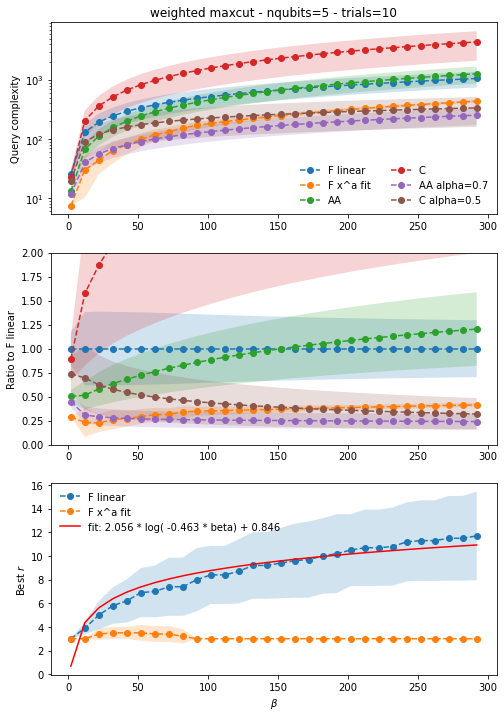

In [123]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], beta_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], beta_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'$\beta$')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$')
plot_band(axs[2], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[2], beta_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

def func(x, a, b, c):
    return a * np.log(np.abs(b) * x) + c

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[2].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * log( %5.3f * beta) + %5.3f' % tuple(popt))
axs[2].legend(loc='upper left', frameon=False)

<ipython-input-129-d024b8d3ca69>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-129-d024b8d3ca69>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-129-d024b8d3ca69>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-129-d024b8d3ca69>:4: Runt

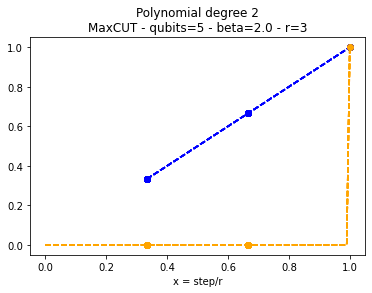

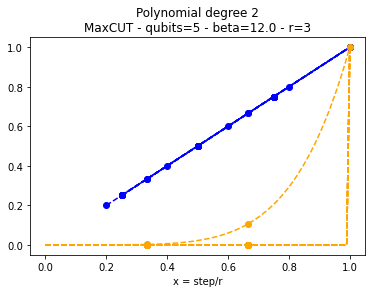

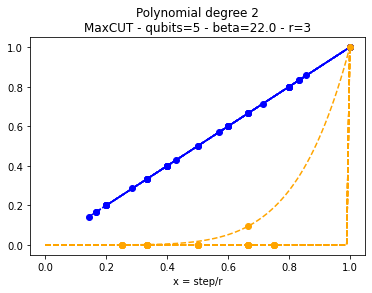

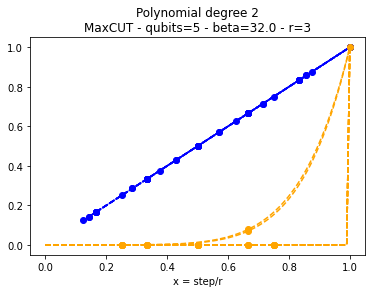

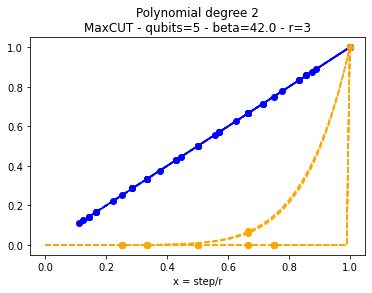

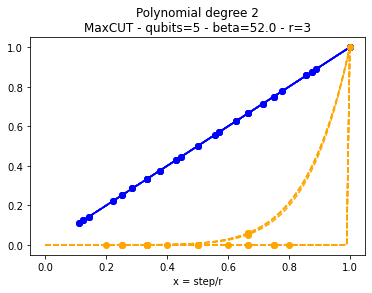

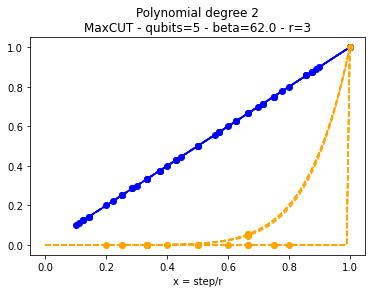

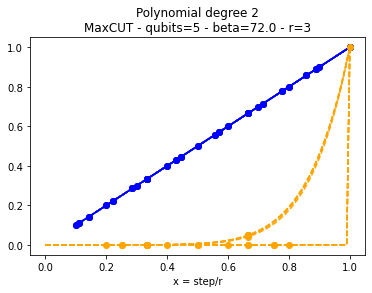

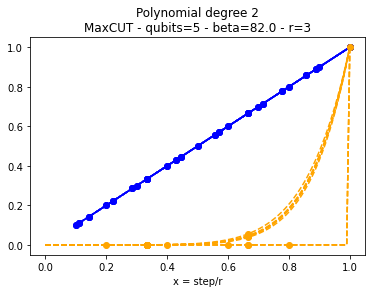

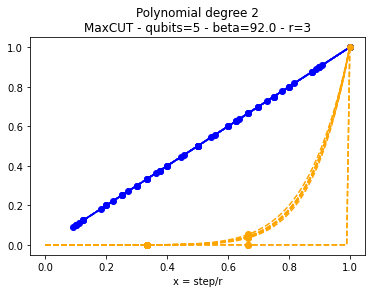

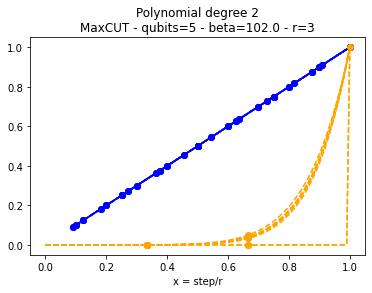

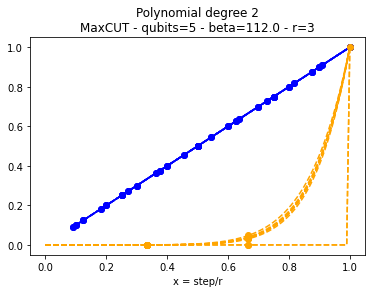

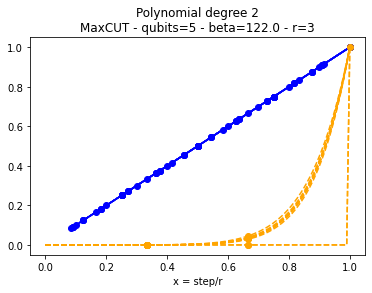

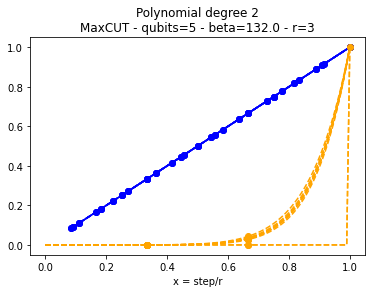

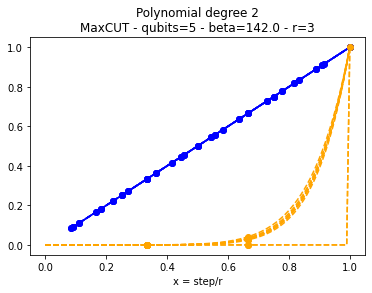

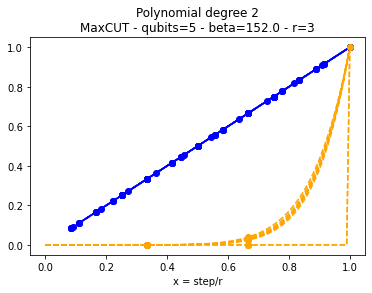

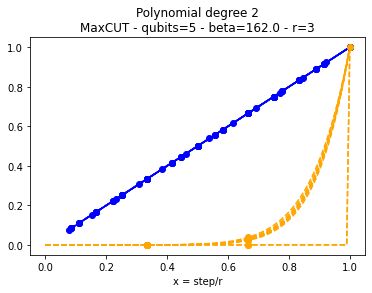

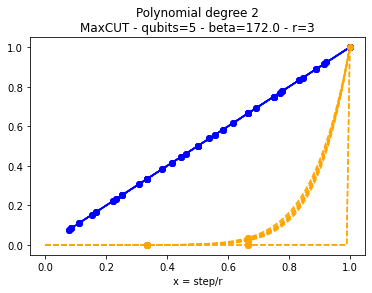

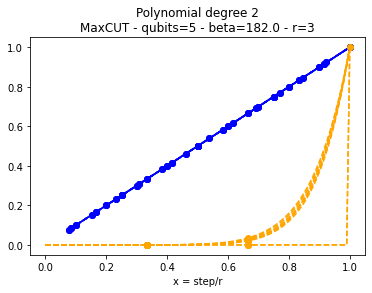

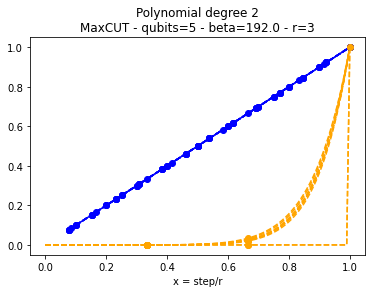

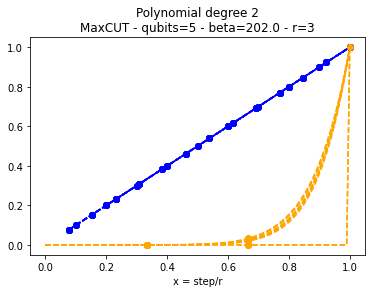

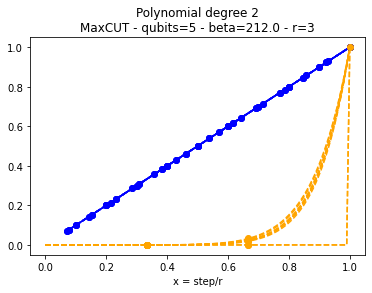

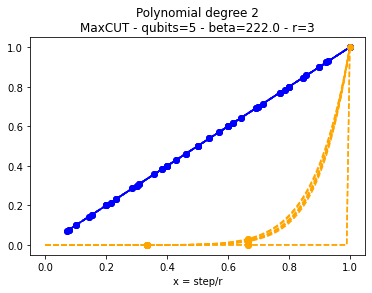

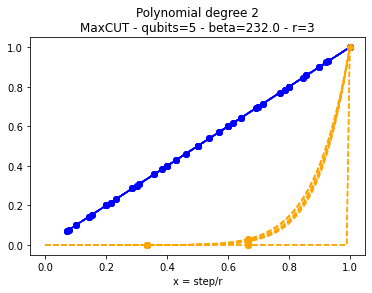

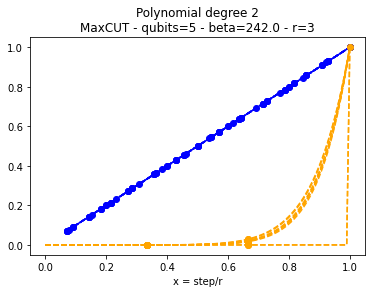

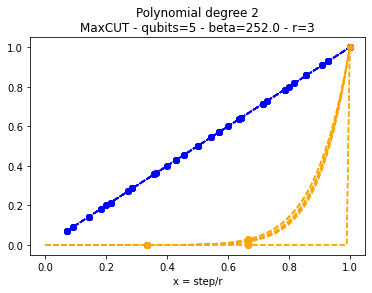

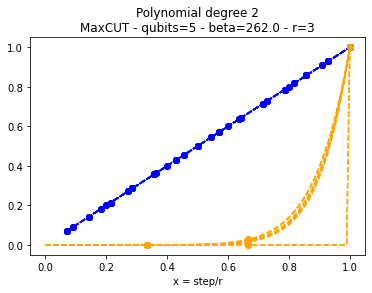

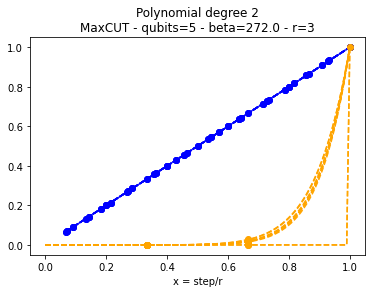

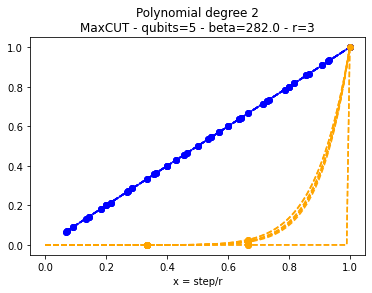

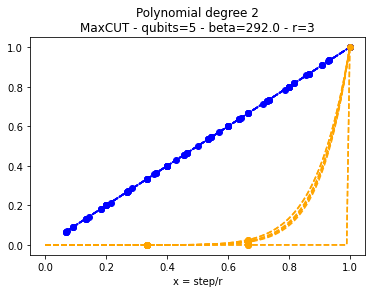

In [129]:
# plot
x = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    #plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        #plt.plot(x, [myschedule(i, parameters[ii][jj]) for i in x], color='orange');
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        
    plt.xlabel('x = step/r')
    #plt.legend(ncol=3);